In [5]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

C:\Users\Rudy\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/195, d1=0.713, d2=0.695 g=0.692
>1, 2/195, d1=0.644, d2=0.697 g=0.690


C:\Users\Rudy\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 3/195, d1=0.588, d2=0.702 g=0.686
>1, 4/195, d1=0.496, d2=0.714 g=0.676
>1, 5/195, d1=0.388, d2=0.741 g=0.657
>1, 6/195, d1=0.276, d2=0.786 g=0.640
>1, 7/195, d1=0.171, d2=0.813 g=0.657
>1, 8/195, d1=0.130, d2=0.767 g=0.734
>1, 9/195, d1=0.093, d2=0.663 g=0.838
>1, 10/195, d1=0.078, d2=0.607 g=0.891
>1, 11/195, d1=0.085, d2=0.606 g=0.862
>1, 12/195, d1=0.066, d2=0.623 g=0.822
>1, 13/195, d1=0.142, d2=0.656 g=0.770
>1, 14/195, d1=0.064, d2=0.672 g=0.756
>1, 15/195, d1=0.060, d2=0.698 g=0.744
>1, 16/195, d1=0.038, d2=0.763 g=0.722
>1, 17/195, d1=0.034, d2=0.916 g=0.654
>1, 18/195, d1=0.043, d2=1.068 g=0.611
>1, 19/195, d1=0.065, d2=1.040 g=0.654
>1, 20/195, d1=0.137, d2=0.890 g=0.751
>1, 21/195, d1=0.179, d2=0.733 g=0.871
>1, 22/195, d1=0.219, d2=0.645 g=0.980
>1, 23/195, d1=0.180, d2=0.535 g=1.081
>1, 24/195, d1=0.133, d2=0.480 g=1.150
>1, 25/195, d1=0.097, d2=0.448 g=1.164
>1, 26/195, d1=0.067, d2=0.455 g=1.100
>1, 27/195, d1=0.052, d2=0.493 g=1.000
>1, 28/195, d1=0.032, d2=0.536 g

>2, 18/195, d1=0.372, d2=0.361 g=2.073
>2, 19/195, d1=0.337, d2=0.325 g=2.199
>2, 20/195, d1=0.385, d2=0.286 g=2.328
>2, 21/195, d1=0.232, d2=0.213 g=2.607
>2, 22/195, d1=0.291, d2=0.202 g=2.741
>2, 23/195, d1=0.300, d2=0.184 g=2.630
>2, 24/195, d1=0.147, d2=0.177 g=3.050
>2, 25/195, d1=0.216, d2=0.138 g=3.197
>2, 26/195, d1=0.171, d2=0.272 g=3.176
>2, 27/195, d1=0.182, d2=0.253 g=3.374
>2, 28/195, d1=0.217, d2=0.323 g=3.385
>2, 29/195, d1=0.349, d2=0.513 g=2.823
>2, 30/195, d1=0.469, d2=0.545 g=2.258
>2, 31/195, d1=0.428, d2=0.410 g=2.439
>2, 32/195, d1=0.689, d2=0.288 g=2.335
>2, 33/195, d1=0.287, d2=0.324 g=2.366
>2, 34/195, d1=0.250, d2=0.388 g=3.186
>2, 35/195, d1=0.440, d2=0.170 g=3.214
>2, 36/195, d1=0.476, d2=0.500 g=4.740
>2, 37/195, d1=0.861, d2=0.112 g=3.700
>2, 38/195, d1=0.550, d2=0.537 g=4.247
>2, 39/195, d1=0.422, d2=0.088 g=4.475
>2, 40/195, d1=0.461, d2=0.313 g=4.927
>2, 41/195, d1=0.495, d2=0.070 g=4.363
>2, 42/195, d1=0.599, d2=0.467 g=7.256
>2, 43/195, d1=0.885, d2=

>3, 31/195, d1=0.682, d2=0.568 g=1.672
>3, 32/195, d1=0.623, d2=0.567 g=1.839
>3, 33/195, d1=0.622, d2=0.507 g=1.660
>3, 34/195, d1=0.781, d2=0.458 g=1.529
>3, 35/195, d1=0.653, d2=0.514 g=1.466
>3, 36/195, d1=0.685, d2=0.605 g=1.496
>3, 37/195, d1=0.597, d2=0.559 g=1.519
>3, 38/195, d1=0.714, d2=0.454 g=1.487
>3, 39/195, d1=0.731, d2=0.465 g=1.323
>3, 40/195, d1=0.565, d2=0.561 g=1.248
>3, 41/195, d1=0.573, d2=0.500 g=1.312
>3, 42/195, d1=0.592, d2=0.503 g=1.273
>3, 43/195, d1=0.606, d2=0.530 g=1.224
>3, 44/195, d1=0.512, d2=0.516 g=1.305
>3, 45/195, d1=0.629, d2=0.486 g=1.322
>3, 46/195, d1=0.512, d2=0.456 g=1.300
>3, 47/195, d1=0.468, d2=0.416 g=1.352
>3, 48/195, d1=0.512, d2=0.399 g=1.320
>3, 49/195, d1=0.512, d2=0.446 g=1.397
>3, 50/195, d1=0.458, d2=0.411 g=1.428
>3, 51/195, d1=0.461, d2=0.389 g=1.470
>3, 52/195, d1=0.448, d2=0.385 g=1.457
>3, 53/195, d1=0.507, d2=0.458 g=1.472
>3, 54/195, d1=0.530, d2=0.437 g=1.522
>3, 55/195, d1=0.563, d2=0.405 g=1.540
>3, 56/195, d1=0.575, d2=

>4, 44/195, d1=0.397, d2=0.562 g=1.640
>4, 45/195, d1=0.509, d2=0.688 g=1.653
>4, 46/195, d1=0.523, d2=0.786 g=1.987
>4, 47/195, d1=0.639, d2=0.319 g=2.314
>4, 48/195, d1=0.563, d2=0.193 g=2.305
>4, 49/195, d1=0.396, d2=0.189 g=2.466
>4, 50/195, d1=0.383, d2=0.208 g=2.389
>4, 51/195, d1=0.256, d2=0.200 g=2.670
>4, 52/195, d1=0.339, d2=0.206 g=2.490
>4, 53/195, d1=0.288, d2=0.244 g=2.399
>4, 54/195, d1=0.446, d2=0.297 g=2.315
>4, 55/195, d1=0.356, d2=0.315 g=2.303
>4, 56/195, d1=0.435, d2=0.315 g=2.167
>4, 57/195, d1=0.369, d2=0.387 g=1.988
>4, 58/195, d1=0.321, d2=0.527 g=1.836
>4, 59/195, d1=0.402, d2=0.698 g=1.773
>4, 60/195, d1=0.899, d2=1.079 g=1.632
>4, 61/195, d1=0.846, d2=0.937 g=1.801
>4, 62/195, d1=0.879, d2=0.719 g=2.077
>4, 63/195, d1=1.124, d2=0.472 g=1.978
>4, 64/195, d1=0.881, d2=0.614 g=2.136
>4, 65/195, d1=1.152, d2=0.385 g=2.203
>4, 66/195, d1=0.978, d2=0.347 g=1.891
>4, 67/195, d1=0.761, d2=0.448 g=1.953
>4, 68/195, d1=0.587, d2=0.392 g=1.985
>4, 69/195, d1=0.639, d2=

>5, 57/195, d1=0.963, d2=0.424 g=1.656
>5, 58/195, d1=0.936, d2=0.419 g=1.474
>5, 59/195, d1=0.784, d2=0.448 g=1.458
>5, 60/195, d1=0.830, d2=0.495 g=1.424
>5, 61/195, d1=0.793, d2=0.438 g=1.319
>5, 62/195, d1=0.727, d2=0.458 g=1.298
>5, 63/195, d1=0.723, d2=0.478 g=1.307
>5, 64/195, d1=0.643, d2=0.516 g=1.310
>5, 65/195, d1=0.706, d2=0.515 g=1.338
>5, 66/195, d1=0.721, d2=0.526 g=1.279
>5, 67/195, d1=0.633, d2=0.518 g=1.270
>5, 68/195, d1=0.704, d2=0.469 g=1.295
>5, 69/195, d1=0.696, d2=0.509 g=1.214
>5, 70/195, d1=0.589, d2=0.494 g=1.236
>5, 71/195, d1=0.622, d2=0.508 g=1.233
>5, 72/195, d1=0.603, d2=0.529 g=1.238
>5, 73/195, d1=0.538, d2=0.502 g=1.244
>5, 74/195, d1=0.526, d2=0.485 g=1.239
>5, 75/195, d1=0.607, d2=0.525 g=1.241
>5, 76/195, d1=0.458, d2=0.511 g=1.235
>5, 77/195, d1=0.496, d2=0.574 g=1.155
>5, 78/195, d1=0.504, d2=0.564 g=1.176
>5, 79/195, d1=0.463, d2=0.502 g=1.166
>5, 80/195, d1=0.449, d2=0.603 g=1.118
>5, 81/195, d1=0.429, d2=0.541 g=1.254
>5, 82/195, d1=0.391, d2=

>6, 70/195, d1=0.647, d2=0.446 g=1.790
>6, 71/195, d1=0.647, d2=0.407 g=1.777
>6, 72/195, d1=0.626, d2=0.414 g=1.668
>6, 73/195, d1=0.524, d2=0.451 g=1.628
>6, 74/195, d1=0.523, d2=0.458 g=1.781
>6, 75/195, d1=0.586, d2=0.340 g=1.704
>6, 76/195, d1=0.561, d2=0.476 g=1.585
>6, 77/195, d1=0.488, d2=0.506 g=1.696
>6, 78/195, d1=0.599, d2=0.483 g=1.755
>6, 79/195, d1=0.570, d2=0.442 g=1.706
>6, 80/195, d1=0.621, d2=0.590 g=1.885
>6, 81/195, d1=0.568, d2=0.633 g=2.163
>6, 82/195, d1=0.697, d2=0.665 g=2.368
>6, 83/195, d1=0.654, d2=0.418 g=2.388
>6, 84/195, d1=0.630, d2=0.503 g=1.652
>6, 85/195, d1=0.684, d2=0.634 g=1.598
>6, 86/195, d1=0.539, d2=0.607 g=1.607
>6, 87/195, d1=0.619, d2=0.560 g=1.414
>6, 88/195, d1=0.511, d2=0.639 g=1.391
>6, 89/195, d1=0.749, d2=0.667 g=1.298
>6, 90/195, d1=0.675, d2=0.661 g=1.407
>6, 91/195, d1=0.651, d2=0.639 g=1.507
>6, 92/195, d1=0.692, d2=0.528 g=1.506
>6, 93/195, d1=0.636, d2=0.494 g=1.494
>6, 94/195, d1=0.641, d2=0.495 g=1.454
>6, 95/195, d1=0.608, d2=

>7, 83/195, d1=0.798, d2=0.584 g=1.235
>7, 84/195, d1=0.684, d2=0.572 g=1.292
>7, 85/195, d1=0.718, d2=0.553 g=1.280
>7, 86/195, d1=0.713, d2=0.534 g=1.271
>7, 87/195, d1=0.723, d2=0.570 g=1.258
>7, 88/195, d1=0.661, d2=0.568 g=1.288
>7, 89/195, d1=0.737, d2=0.549 g=1.239
>7, 90/195, d1=0.709, d2=0.633 g=1.258
>7, 91/195, d1=0.776, d2=0.556 g=1.236
>7, 92/195, d1=0.740, d2=0.562 g=1.273
>7, 93/195, d1=0.844, d2=0.542 g=1.218
>7, 94/195, d1=0.787, d2=0.574 g=1.189
>7, 95/195, d1=0.766, d2=0.563 g=1.205
>7, 96/195, d1=0.819, d2=0.572 g=1.165
>7, 97/195, d1=0.683, d2=0.571 g=1.191
>7, 98/195, d1=0.754, d2=0.538 g=1.206
>7, 99/195, d1=0.732, d2=0.581 g=1.198
>7, 100/195, d1=0.750, d2=0.631 g=1.158
>7, 101/195, d1=0.794, d2=0.544 g=1.192
>7, 102/195, d1=0.739, d2=0.545 g=1.231
>7, 103/195, d1=0.764, d2=0.555 g=1.200
>7, 104/195, d1=0.705, d2=0.540 g=1.204
>7, 105/195, d1=0.682, d2=0.509 g=1.197
>7, 106/195, d1=0.680, d2=0.544 g=1.210
>7, 107/195, d1=0.712, d2=0.547 g=1.184
>7, 108/195, d1=0

>8, 96/195, d1=0.525, d2=0.420 g=1.848
>8, 97/195, d1=0.500, d2=0.369 g=1.801
>8, 98/195, d1=0.586, d2=0.477 g=1.584
>8, 99/195, d1=0.428, d2=0.482 g=1.557
>8, 100/195, d1=0.484, d2=0.469 g=1.654
>8, 101/195, d1=0.586, d2=0.540 g=1.471
>8, 102/195, d1=0.586, d2=0.523 g=1.481
>8, 103/195, d1=0.640, d2=0.573 g=1.377
>8, 104/195, d1=0.573, d2=0.499 g=1.357
>8, 105/195, d1=0.715, d2=0.553 g=1.293
>8, 106/195, d1=0.587, d2=0.633 g=1.277
>8, 107/195, d1=0.576, d2=0.566 g=1.398
>8, 108/195, d1=0.725, d2=0.495 g=1.376
>8, 109/195, d1=0.698, d2=0.506 g=1.337
>8, 110/195, d1=0.652, d2=0.474 g=1.370
>8, 111/195, d1=0.631, d2=0.451 g=1.331
>8, 112/195, d1=0.511, d2=0.536 g=1.403
>8, 113/195, d1=0.547, d2=0.456 g=1.479
>8, 114/195, d1=0.561, d2=0.461 g=1.407
>8, 115/195, d1=0.630, d2=0.502 g=1.434
>8, 116/195, d1=0.604, d2=0.481 g=1.353
>8, 117/195, d1=0.615, d2=0.594 g=1.327
>8, 118/195, d1=0.635, d2=0.534 g=1.259
>8, 119/195, d1=0.639, d2=0.584 g=1.205
>8, 120/195, d1=0.623, d2=0.550 g=1.278
>8, 

>9, 109/195, d1=0.455, d2=0.387 g=1.813
>9, 110/195, d1=0.454, d2=0.407 g=1.884
>9, 111/195, d1=0.512, d2=0.460 g=2.013
>9, 112/195, d1=0.572, d2=0.344 g=1.864
>9, 113/195, d1=0.579, d2=0.440 g=1.951
>9, 114/195, d1=0.590, d2=0.342 g=1.884
>9, 115/195, d1=0.700, d2=0.491 g=1.774
>9, 116/195, d1=0.658, d2=0.400 g=1.865
>9, 117/195, d1=0.597, d2=0.359 g=1.734
>9, 118/195, d1=0.449, d2=0.388 g=1.788
>9, 119/195, d1=0.643, d2=0.370 g=1.746
>9, 120/195, d1=0.472, d2=0.377 g=1.649
>9, 121/195, d1=0.528, d2=0.415 g=1.698
>9, 122/195, d1=0.432, d2=0.420 g=1.686
>9, 123/195, d1=0.447, d2=0.423 g=1.587
>9, 124/195, d1=0.397, d2=0.632 g=1.567
>9, 125/195, d1=0.612, d2=0.802 g=1.466
>9, 126/195, d1=0.772, d2=1.333 g=1.574
>9, 127/195, d1=0.974, d2=0.920 g=1.830
>9, 128/195, d1=1.059, d2=0.506 g=2.081
>9, 129/195, d1=1.056, d2=0.395 g=2.032
>9, 130/195, d1=0.797, d2=0.476 g=1.974
>9, 131/195, d1=0.730, d2=0.474 g=1.828
>9, 132/195, d1=0.640, d2=0.479 g=1.639
>9, 133/195, d1=0.519, d2=0.448 g=1.703


>10, 120/195, d1=0.535, d2=0.507 g=1.500
>10, 121/195, d1=0.527, d2=0.436 g=1.475
>10, 122/195, d1=0.601, d2=0.479 g=1.351
>10, 123/195, d1=0.540, d2=0.549 g=1.395
>10, 124/195, d1=0.563, d2=0.555 g=1.434
>10, 125/195, d1=0.590, d2=0.526 g=1.457
>10, 126/195, d1=0.583, d2=0.465 g=1.378
>10, 127/195, d1=0.618, d2=0.599 g=1.355
>10, 128/195, d1=0.590, d2=0.531 g=1.401
>10, 129/195, d1=0.645, d2=0.536 g=1.397
>10, 130/195, d1=0.680, d2=0.546 g=1.406
>10, 131/195, d1=0.559, d2=0.457 g=1.400
>10, 132/195, d1=0.693, d2=0.501 g=1.379
>10, 133/195, d1=0.642, d2=0.528 g=1.445
>10, 134/195, d1=0.541, d2=0.486 g=1.471
>10, 135/195, d1=0.561, d2=0.427 g=1.458
>10, 136/195, d1=0.564, d2=0.503 g=1.467
>10, 137/195, d1=0.620, d2=0.518 g=1.576
>10, 138/195, d1=0.619, d2=0.392 g=1.591
>10, 139/195, d1=0.656, d2=0.493 g=1.454
>10, 140/195, d1=0.611, d2=0.583 g=1.442
>10, 141/195, d1=0.567, d2=0.555 g=1.447
>10, 142/195, d1=0.626, d2=0.638 g=1.507
>10, 143/195, d1=0.646, d2=0.566 g=1.453
>10, 144/195, d1

>11, 127/195, d1=0.655, d2=0.574 g=1.191
>11, 128/195, d1=0.773, d2=0.603 g=1.125
>11, 129/195, d1=0.646, d2=0.553 g=1.105
>11, 130/195, d1=0.661, d2=0.615 g=1.110
>11, 131/195, d1=0.652, d2=0.592 g=1.144
>11, 132/195, d1=0.620, d2=0.525 g=1.176
>11, 133/195, d1=0.645, d2=0.547 g=1.131
>11, 134/195, d1=0.612, d2=0.557 g=1.142
>11, 135/195, d1=0.597, d2=0.529 g=1.159
>11, 136/195, d1=0.563, d2=0.532 g=1.149
>11, 137/195, d1=0.573, d2=0.546 g=1.151
>11, 138/195, d1=0.514, d2=0.505 g=1.157
>11, 139/195, d1=0.511, d2=0.521 g=1.151
>11, 140/195, d1=0.471, d2=0.517 g=1.192
>11, 141/195, d1=0.443, d2=0.517 g=1.230
>11, 142/195, d1=0.433, d2=0.518 g=1.218
>11, 143/195, d1=0.462, d2=0.520 g=1.251
>11, 144/195, d1=0.395, d2=0.547 g=1.200
>11, 145/195, d1=0.408, d2=0.517 g=1.245
>11, 146/195, d1=0.431, d2=0.474 g=1.225
>11, 147/195, d1=0.412, d2=0.545 g=1.192
>11, 148/195, d1=0.443, d2=0.554 g=1.268
>11, 149/195, d1=0.388, d2=0.527 g=1.242
>11, 150/195, d1=0.465, d2=0.573 g=1.192
>11, 151/195, d1

>12, 136/195, d1=0.601, d2=0.471 g=1.491
>12, 137/195, d1=0.611, d2=0.437 g=1.464
>12, 138/195, d1=0.584, d2=0.475 g=1.463
>12, 139/195, d1=0.622, d2=0.500 g=1.396
>12, 140/195, d1=0.596, d2=0.576 g=1.428
>12, 141/195, d1=0.668, d2=0.466 g=1.381
>12, 142/195, d1=0.709, d2=0.547 g=1.317
>12, 143/195, d1=0.666, d2=0.554 g=1.230
>12, 144/195, d1=0.725, d2=0.557 g=1.139
>12, 145/195, d1=0.706, d2=0.601 g=1.056
>12, 146/195, d1=0.628, d2=0.605 g=1.021
>12, 147/195, d1=0.667, d2=0.606 g=1.030
>12, 148/195, d1=0.677, d2=0.576 g=1.074
>12, 149/195, d1=0.622, d2=0.589 g=1.127
>12, 150/195, d1=0.691, d2=0.543 g=1.078
>12, 151/195, d1=0.682, d2=0.507 g=1.110
>12, 152/195, d1=0.676, d2=0.535 g=1.129
>12, 153/195, d1=0.695, d2=0.512 g=1.128
>12, 154/195, d1=0.507, d2=0.549 g=1.181
>12, 155/195, d1=0.534, d2=0.482 g=1.214
>12, 156/195, d1=0.642, d2=0.441 g=1.244
>12, 157/195, d1=0.546, d2=0.486 g=1.203
>12, 158/195, d1=0.507, d2=0.503 g=1.206
>12, 159/195, d1=0.521, d2=0.524 g=1.188
>12, 160/195, d1

>13, 145/195, d1=0.392, d2=0.542 g=1.219
>13, 146/195, d1=0.358, d2=0.635 g=1.119
>13, 147/195, d1=0.343, d2=0.788 g=1.350
>13, 148/195, d1=0.606, d2=0.621 g=1.246
>13, 149/195, d1=0.583, d2=0.975 g=1.362
>13, 150/195, d1=0.657, d2=0.488 g=1.346
>13, 151/195, d1=0.859, d2=0.464 g=1.136
>13, 152/195, d1=0.689, d2=0.649 g=1.032
>13, 153/195, d1=0.557, d2=0.742 g=1.096
>13, 154/195, d1=0.578, d2=0.644 g=1.070
>13, 155/195, d1=0.684, d2=0.757 g=1.119
>13, 156/195, d1=0.679, d2=0.626 g=1.151
>13, 157/195, d1=0.705, d2=0.575 g=1.234
>13, 158/195, d1=0.671, d2=0.614 g=1.274
>13, 159/195, d1=0.685, d2=0.533 g=1.405
>13, 160/195, d1=0.568, d2=0.413 g=1.374
>13, 161/195, d1=0.561, d2=0.454 g=1.450
>13, 162/195, d1=0.518, d2=0.443 g=1.492
>13, 163/195, d1=0.553, d2=0.419 g=1.440
>13, 164/195, d1=0.497, d2=0.442 g=1.433
>13, 165/195, d1=0.393, d2=0.420 g=1.531
>13, 166/195, d1=0.458, d2=0.471 g=1.500
>13, 167/195, d1=0.517, d2=0.454 g=1.397
>13, 168/195, d1=0.478, d2=0.464 g=1.411
>13, 169/195, d1

>14, 154/195, d1=0.542, d2=0.602 g=1.134
>14, 155/195, d1=0.628, d2=0.576 g=1.121
>14, 156/195, d1=0.536, d2=0.605 g=1.156
>14, 157/195, d1=0.519, d2=0.542 g=1.181
>14, 158/195, d1=0.494, d2=0.577 g=1.267
>14, 159/195, d1=0.570, d2=0.518 g=1.321
>14, 160/195, d1=0.520, d2=0.427 g=1.412
>14, 161/195, d1=0.583, d2=0.470 g=1.488
>14, 162/195, d1=0.494, d2=0.404 g=1.557
>14, 163/195, d1=0.559, d2=0.379 g=1.613
>14, 164/195, d1=0.526, d2=0.418 g=1.634
>14, 165/195, d1=0.470, d2=0.362 g=1.668
>14, 166/195, d1=0.481, d2=0.354 g=1.646
>14, 167/195, d1=0.479, d2=0.408 g=1.767
>14, 168/195, d1=0.553, d2=0.451 g=1.864
>14, 169/195, d1=0.514, d2=0.358 g=1.830
>14, 170/195, d1=0.621, d2=0.407 g=1.656
>14, 171/195, d1=0.623, d2=0.440 g=1.592
>14, 172/195, d1=0.586, d2=0.498 g=1.521
>14, 173/195, d1=0.628, d2=0.470 g=1.557
>14, 174/195, d1=0.637, d2=0.442 g=1.578
>14, 175/195, d1=0.768, d2=0.450 g=1.475
>14, 176/195, d1=0.663, d2=0.463 g=1.516
>14, 177/195, d1=0.600, d2=0.466 g=1.445
>14, 178/195, d1

>15, 163/195, d1=0.631, d2=0.549 g=1.283
>15, 164/195, d1=0.731, d2=0.534 g=1.337
>15, 165/195, d1=0.678, d2=0.590 g=1.351
>15, 166/195, d1=0.669, d2=0.475 g=1.392
>15, 167/195, d1=0.655, d2=0.574 g=1.427
>15, 168/195, d1=0.668, d2=0.493 g=1.451
>15, 169/195, d1=0.694, d2=0.468 g=1.428
>15, 170/195, d1=0.669, d2=0.515 g=1.408
>15, 171/195, d1=0.658, d2=0.432 g=1.317
>15, 172/195, d1=0.658, d2=0.514 g=1.325
>15, 173/195, d1=0.621, d2=0.494 g=1.322
>15, 174/195, d1=0.608, d2=0.519 g=1.329
>15, 175/195, d1=0.552, d2=0.462 g=1.370
>15, 176/195, d1=0.634, d2=0.578 g=1.420
>15, 177/195, d1=0.613, d2=0.632 g=1.567
>15, 178/195, d1=0.693, d2=0.376 g=1.484
>15, 179/195, d1=0.758, d2=0.509 g=1.307
>15, 180/195, d1=0.669, d2=0.574 g=1.371
>15, 181/195, d1=0.791, d2=0.540 g=1.303
>15, 182/195, d1=0.633, d2=0.522 g=1.333
>15, 183/195, d1=0.664, d2=0.513 g=1.262
>15, 184/195, d1=0.580, d2=0.547 g=1.268
>15, 185/195, d1=0.652, d2=0.495 g=1.310
>15, 186/195, d1=0.619, d2=0.479 g=1.313
>15, 187/195, d1

>16, 172/195, d1=0.746, d2=0.583 g=1.167
>16, 173/195, d1=0.694, d2=0.585 g=1.265
>16, 174/195, d1=0.712, d2=0.520 g=1.274
>16, 175/195, d1=0.721, d2=0.539 g=1.265
>16, 176/195, d1=0.696, d2=0.462 g=1.300
>16, 177/195, d1=0.623, d2=0.540 g=1.297
>16, 178/195, d1=0.628, d2=0.486 g=1.393
>16, 179/195, d1=0.699, d2=0.449 g=1.252
>16, 180/195, d1=0.549, d2=0.503 g=1.311
>16, 181/195, d1=0.579, d2=0.469 g=1.227
>16, 182/195, d1=0.584, d2=0.477 g=1.287
>16, 183/195, d1=0.514, d2=0.471 g=1.325
>16, 184/195, d1=0.509, d2=0.470 g=1.348
>16, 185/195, d1=0.490, d2=0.458 g=1.350
>16, 186/195, d1=0.525, d2=0.440 g=1.263
>16, 187/195, d1=0.533, d2=0.561 g=1.269
>16, 188/195, d1=0.537, d2=0.716 g=1.282
>16, 189/195, d1=0.605, d2=0.672 g=1.256
>16, 190/195, d1=0.591, d2=0.524 g=1.205
>16, 191/195, d1=0.585, d2=0.667 g=1.198
>16, 192/195, d1=0.784, d2=0.810 g=1.354
>16, 193/195, d1=0.690, d2=0.521 g=1.451
>16, 194/195, d1=0.766, d2=0.468 g=1.388
>16, 195/195, d1=0.769, d2=0.540 g=1.290
>17, 1/195, d1=0

>17, 181/195, d1=0.561, d2=0.495 g=1.295
>17, 182/195, d1=0.453, d2=0.490 g=1.345
>17, 183/195, d1=0.502, d2=0.496 g=1.313
>17, 184/195, d1=0.490, d2=0.597 g=1.339
>17, 185/195, d1=0.537, d2=0.546 g=1.360
>17, 186/195, d1=0.555, d2=0.487 g=1.324
>17, 187/195, d1=0.579, d2=0.619 g=1.345
>17, 188/195, d1=0.529, d2=0.522 g=1.405
>17, 189/195, d1=0.696, d2=0.546 g=1.236
>17, 190/195, d1=0.735, d2=0.625 g=1.249
>17, 191/195, d1=0.677, d2=0.660 g=1.199
>17, 192/195, d1=0.695, d2=0.631 g=1.198
>17, 193/195, d1=0.687, d2=0.583 g=1.205
>17, 194/195, d1=0.792, d2=0.560 g=1.155
>17, 195/195, d1=0.699, d2=0.624 g=1.133
>18, 1/195, d1=0.718, d2=0.641 g=1.162
>18, 2/195, d1=0.696, d2=0.572 g=1.125
>18, 3/195, d1=0.701, d2=0.522 g=1.193
>18, 4/195, d1=0.648, d2=0.598 g=1.273
>18, 5/195, d1=0.673, d2=0.558 g=1.313
>18, 6/195, d1=0.647, d2=0.504 g=1.411
>18, 7/195, d1=0.675, d2=0.514 g=1.414
>18, 8/195, d1=0.677, d2=0.489 g=1.415
>18, 9/195, d1=0.747, d2=0.501 g=1.437
>18, 10/195, d1=0.697, d2=0.482 g=

>18, 190/195, d1=0.402, d2=0.395 g=1.515
>18, 191/195, d1=0.340, d2=0.461 g=1.612
>18, 192/195, d1=0.367, d2=0.418 g=1.862
>18, 193/195, d1=0.349, d2=0.352 g=1.853
>18, 194/195, d1=0.451, d2=0.343 g=1.754
>18, 195/195, d1=0.355, d2=0.407 g=1.634
>19, 1/195, d1=0.396, d2=0.602 g=1.593
>19, 2/195, d1=0.474, d2=0.539 g=1.590
>19, 3/195, d1=0.617, d2=0.536 g=1.465
>19, 4/195, d1=0.570, d2=0.606 g=1.482
>19, 5/195, d1=0.576, d2=0.515 g=1.883
>19, 6/195, d1=0.603, d2=0.429 g=1.932
>19, 7/195, d1=0.650, d2=0.514 g=1.868
>19, 8/195, d1=0.532, d2=0.744 g=2.093
>19, 9/195, d1=0.538, d2=0.563 g=2.158
>19, 10/195, d1=0.719, d2=1.095 g=2.020
>19, 11/195, d1=0.908, d2=1.138 g=1.916
>19, 12/195, d1=1.094, d2=0.669 g=1.609
>19, 13/195, d1=1.040, d2=0.548 g=1.212
>19, 14/195, d1=1.000, d2=0.662 g=1.036
>19, 15/195, d1=0.750, d2=0.678 g=1.103
>19, 16/195, d1=0.652, d2=0.557 g=1.311
>19, 17/195, d1=0.647, d2=0.467 g=1.474
>19, 18/195, d1=0.473, d2=0.333 g=1.744
>19, 19/195, d1=0.450, d2=0.322 g=2.006
>19

>20, 4/195, d1=0.395, d2=0.372 g=1.741
>20, 5/195, d1=0.391, d2=0.328 g=1.643
>20, 6/195, d1=0.283, d2=0.522 g=1.712
>20, 7/195, d1=0.384, d2=0.663 g=2.056
>20, 8/195, d1=0.562, d2=0.315 g=1.839
>20, 9/195, d1=0.521, d2=0.418 g=1.623
>20, 10/195, d1=0.465, d2=0.530 g=1.429
>20, 11/195, d1=0.312, d2=0.631 g=1.888
>20, 12/195, d1=0.662, d2=0.426 g=1.891
>20, 13/195, d1=0.614, d2=0.536 g=1.770
>20, 14/195, d1=0.573, d2=0.361 g=1.630
>20, 15/195, d1=0.512, d2=0.587 g=1.706
>20, 16/195, d1=0.502, d2=0.430 g=1.835
>20, 17/195, d1=0.481, d2=0.384 g=1.845
>20, 18/195, d1=0.519, d2=0.390 g=1.783
>20, 19/195, d1=0.419, d2=0.496 g=1.782
>20, 20/195, d1=0.453, d2=0.463 g=1.752
>20, 21/195, d1=0.633, d2=0.490 g=1.582
>20, 22/195, d1=0.612, d2=0.521 g=1.510
>20, 23/195, d1=0.631, d2=0.631 g=1.631
>20, 24/195, d1=0.802, d2=0.427 g=1.571
>20, 25/195, d1=0.675, d2=0.534 g=1.536
>20, 26/195, d1=0.761, d2=0.549 g=1.486
>20, 27/195, d1=0.688, d2=0.496 g=1.431
>20, 28/195, d1=0.600, d2=0.550 g=1.483
>20, 2

>21, 13/195, d1=0.663, d2=0.580 g=1.220
>21, 14/195, d1=0.580, d2=0.542 g=1.150
>21, 15/195, d1=0.646, d2=0.572 g=1.136
>21, 16/195, d1=0.579, d2=0.606 g=1.217
>21, 17/195, d1=0.599, d2=0.547 g=1.158
>21, 18/195, d1=0.551, d2=0.597 g=1.237
>21, 19/195, d1=0.610, d2=0.483 g=1.234
>21, 20/195, d1=0.629, d2=0.525 g=1.200
>21, 21/195, d1=0.536, d2=0.523 g=1.241
>21, 22/195, d1=0.421, d2=0.543 g=1.261
>21, 23/195, d1=0.554, d2=0.474 g=1.341
>21, 24/195, d1=0.541, d2=0.481 g=1.295
>21, 25/195, d1=0.464, d2=0.551 g=1.333
>21, 26/195, d1=0.503, d2=0.550 g=1.370
>21, 27/195, d1=0.602, d2=0.507 g=1.319
>21, 28/195, d1=0.553, d2=0.485 g=1.340
>21, 29/195, d1=0.522, d2=0.580 g=1.330
>21, 30/195, d1=0.556, d2=0.507 g=1.289
>21, 31/195, d1=0.470, d2=0.508 g=1.393
>21, 32/195, d1=0.606, d2=0.495 g=1.304
>21, 33/195, d1=0.481, d2=0.488 g=1.374
>21, 34/195, d1=0.552, d2=0.475 g=1.547
>21, 35/195, d1=0.487, d2=0.483 g=1.586
>21, 36/195, d1=0.572, d2=0.410 g=1.566
>21, 37/195, d1=0.558, d2=0.548 g=1.518


>22, 22/195, d1=0.637, d2=0.659 g=1.208
>22, 23/195, d1=0.612, d2=0.520 g=1.260
>22, 24/195, d1=0.578, d2=0.506 g=1.259
>22, 25/195, d1=0.601, d2=0.508 g=1.307
>22, 26/195, d1=0.642, d2=0.479 g=1.209
>22, 27/195, d1=0.568, d2=0.548 g=1.286
>22, 28/195, d1=0.634, d2=0.475 g=1.261
>22, 29/195, d1=0.578, d2=0.500 g=1.219
>22, 30/195, d1=0.630, d2=0.540 g=1.240
>22, 31/195, d1=0.583, d2=0.566 g=1.160
>22, 32/195, d1=0.579, d2=0.582 g=1.223
>22, 33/195, d1=0.609, d2=0.511 g=1.177
>22, 34/195, d1=0.619, d2=0.607 g=1.163
>22, 35/195, d1=0.602, d2=0.492 g=1.121
>22, 36/195, d1=0.583, d2=0.623 g=1.198
>22, 37/195, d1=0.587, d2=0.522 g=1.199
>22, 38/195, d1=0.520, d2=0.511 g=1.319
>22, 39/195, d1=0.603, d2=0.474 g=1.322
>22, 40/195, d1=0.484, d2=0.489 g=1.321
>22, 41/195, d1=0.572, d2=0.488 g=1.342
>22, 42/195, d1=0.592, d2=0.488 g=1.324
>22, 43/195, d1=0.585, d2=0.475 g=1.317
>22, 44/195, d1=0.488, d2=0.489 g=1.386
>22, 45/195, d1=0.650, d2=0.523 g=1.347
>22, 46/195, d1=0.580, d2=0.504 g=1.294


>23, 31/195, d1=0.588, d2=0.448 g=1.363
>23, 32/195, d1=0.514, d2=0.527 g=1.175
>23, 33/195, d1=0.521, d2=0.559 g=1.026
>23, 34/195, d1=0.533, d2=0.660 g=0.949
>23, 35/195, d1=0.548, d2=0.679 g=0.940
>23, 36/195, d1=0.541, d2=0.717 g=0.972
>23, 37/195, d1=0.580, d2=0.664 g=0.998
>23, 38/195, d1=0.617, d2=0.604 g=0.996
>23, 39/195, d1=0.553, d2=0.687 g=1.063
>23, 40/195, d1=0.621, d2=0.604 g=1.060
>23, 41/195, d1=0.701, d2=0.604 g=1.035
>23, 42/195, d1=0.669, d2=0.693 g=1.141
>23, 43/195, d1=0.637, d2=0.595 g=1.074
>23, 44/195, d1=0.622, d2=0.682 g=1.094
>23, 45/195, d1=0.629, d2=0.621 g=1.067
>23, 46/195, d1=0.586, d2=0.650 g=1.124
>23, 47/195, d1=0.612, d2=0.624 g=1.190
>23, 48/195, d1=0.572, d2=0.674 g=1.300
>23, 49/195, d1=0.733, d2=0.585 g=1.332
>23, 50/195, d1=0.728, d2=0.477 g=1.476
>23, 51/195, d1=0.651, d2=0.422 g=1.456
>23, 52/195, d1=0.563, d2=0.482 g=1.442
>23, 53/195, d1=0.495, d2=0.532 g=1.304
>23, 54/195, d1=0.433, d2=0.482 g=1.294
>23, 55/195, d1=0.483, d2=0.575 g=1.259


>24, 40/195, d1=0.589, d2=0.570 g=1.111
>24, 41/195, d1=0.563, d2=0.579 g=1.175
>24, 42/195, d1=0.559, d2=0.571 g=1.153
>24, 43/195, d1=0.609, d2=0.653 g=1.165
>24, 44/195, d1=0.643, d2=0.578 g=1.191
>24, 45/195, d1=0.668, d2=0.554 g=1.091
>24, 46/195, d1=0.609, d2=0.591 g=1.069
>24, 47/195, d1=0.531, d2=0.568 g=1.080
>24, 48/195, d1=0.547, d2=0.630 g=1.152
>24, 49/195, d1=0.487, d2=0.523 g=1.214
>24, 50/195, d1=0.567, d2=0.532 g=1.244
>24, 51/195, d1=0.522, d2=0.506 g=1.245
>24, 52/195, d1=0.526, d2=0.632 g=1.292
>24, 53/195, d1=0.631, d2=0.561 g=1.257
>24, 54/195, d1=0.638, d2=0.565 g=1.259
>24, 55/195, d1=0.671, d2=0.550 g=1.219
>24, 56/195, d1=0.701, d2=0.614 g=1.220
>24, 57/195, d1=0.664, d2=0.541 g=1.275
>24, 58/195, d1=0.739, d2=0.571 g=1.261
>24, 59/195, d1=0.661, d2=0.591 g=1.245
>24, 60/195, d1=0.625, d2=0.516 g=1.202
>24, 61/195, d1=0.615, d2=0.628 g=1.161
>24, 62/195, d1=0.614, d2=0.631 g=1.166
>24, 63/195, d1=0.711, d2=0.570 g=1.186
>24, 64/195, d1=0.616, d2=0.511 g=1.178


>25, 49/195, d1=0.705, d2=0.633 g=1.214
>25, 50/195, d1=0.605, d2=0.583 g=1.175
>25, 51/195, d1=0.685, d2=0.550 g=1.082
>25, 52/195, d1=0.678, d2=0.589 g=1.032
>25, 53/195, d1=0.587, d2=0.613 g=1.016
>25, 54/195, d1=0.518, d2=0.629 g=1.092
>25, 55/195, d1=0.560, d2=0.529 g=1.165
>25, 56/195, d1=0.537, d2=0.513 g=1.194
>25, 57/195, d1=0.491, d2=0.571 g=1.248
>25, 58/195, d1=0.530, d2=0.544 g=1.321
>25, 59/195, d1=0.540, d2=0.706 g=1.188
>25, 60/195, d1=0.622, d2=1.399 g=1.236
>25, 61/195, d1=0.795, d2=1.796 g=1.292
>25, 62/195, d1=0.907, d2=1.183 g=1.071
>25, 63/195, d1=0.815, d2=0.573 g=1.142
>25, 64/195, d1=0.913, d2=0.543 g=1.084
>25, 65/195, d1=0.766, d2=0.552 g=1.051
>25, 66/195, d1=0.768, d2=0.639 g=1.098
>25, 67/195, d1=0.745, d2=0.508 g=1.142
>25, 68/195, d1=0.793, d2=0.494 g=1.107
>25, 69/195, d1=0.766, d2=0.501 g=1.048
>25, 70/195, d1=0.634, d2=0.607 g=1.078
>25, 71/195, d1=0.602, d2=0.571 g=1.134
>25, 72/195, d1=0.710, d2=0.505 g=1.164
>25, 73/195, d1=0.632, d2=0.532 g=1.148


>26, 58/195, d1=0.626, d2=0.566 g=1.187
>26, 59/195, d1=0.669, d2=0.508 g=1.170
>26, 60/195, d1=0.605, d2=0.563 g=1.259
>26, 61/195, d1=0.637, d2=0.575 g=1.202
>26, 62/195, d1=0.567, d2=0.627 g=1.085
>26, 63/195, d1=0.640, d2=0.618 g=1.034
>26, 64/195, d1=0.594, d2=0.633 g=1.056
>26, 65/195, d1=0.647, d2=0.582 g=1.060
>26, 66/195, d1=0.636, d2=0.588 g=1.064
>26, 67/195, d1=0.632, d2=0.569 g=1.060
>26, 68/195, d1=0.567, d2=0.583 g=1.091
>26, 69/195, d1=0.532, d2=0.601 g=1.100
>26, 70/195, d1=0.653, d2=0.558 g=1.084
>26, 71/195, d1=0.654, d2=0.514 g=1.036
>26, 72/195, d1=0.616, d2=0.562 g=0.987
>26, 73/195, d1=0.595, d2=0.644 g=0.994
>26, 74/195, d1=0.581, d2=0.690 g=1.016
>26, 75/195, d1=0.615, d2=0.691 g=0.981
>26, 76/195, d1=0.747, d2=0.614 g=1.008
>26, 77/195, d1=0.782, d2=0.658 g=0.968
>26, 78/195, d1=0.704, d2=0.620 g=0.987
>26, 79/195, d1=0.728, d2=0.622 g=0.985
>26, 80/195, d1=0.704, d2=0.601 g=1.009
>26, 81/195, d1=0.620, d2=0.697 g=1.002
>26, 82/195, d1=0.651, d2=0.586 g=0.993


>27, 67/195, d1=0.526, d2=0.570 g=1.083
>27, 68/195, d1=0.602, d2=0.615 g=1.028
>27, 69/195, d1=0.600, d2=0.666 g=1.039
>27, 70/195, d1=0.641, d2=0.607 g=1.029
>27, 71/195, d1=0.643, d2=0.704 g=1.040
>27, 72/195, d1=0.625, d2=0.616 g=1.091
>27, 73/195, d1=0.639, d2=0.578 g=1.122
>27, 74/195, d1=0.706, d2=0.578 g=1.083
>27, 75/195, d1=0.653, d2=0.630 g=1.108
>27, 76/195, d1=0.647, d2=0.545 g=1.121
>27, 77/195, d1=0.668, d2=0.584 g=1.164
>27, 78/195, d1=0.629, d2=0.544 g=1.130
>27, 79/195, d1=0.607, d2=0.525 g=1.105
>27, 80/195, d1=0.582, d2=0.565 g=1.036
>27, 81/195, d1=0.556, d2=0.668 g=0.972
>27, 82/195, d1=0.606, d2=0.704 g=1.076
>27, 83/195, d1=0.592, d2=0.582 g=1.107
>27, 84/195, d1=0.608, d2=0.544 g=1.073
>27, 85/195, d1=0.598, d2=0.634 g=1.109
>27, 86/195, d1=0.589, d2=0.591 g=1.123
>27, 87/195, d1=0.568, d2=0.617 g=1.105
>27, 88/195, d1=0.620, d2=0.583 g=1.096
>27, 89/195, d1=0.615, d2=0.576 g=1.095
>27, 90/195, d1=0.656, d2=0.653 g=1.019
>27, 91/195, d1=0.616, d2=0.644 g=1.056


>28, 76/195, d1=0.734, d2=0.562 g=1.160
>28, 77/195, d1=0.664, d2=0.587 g=1.099
>28, 78/195, d1=0.648, d2=0.636 g=1.034
>28, 79/195, d1=0.609, d2=0.656 g=1.002
>28, 80/195, d1=0.575, d2=0.616 g=0.968
>28, 81/195, d1=0.649, d2=0.560 g=1.013
>28, 82/195, d1=0.573, d2=0.614 g=1.046
>28, 83/195, d1=0.613, d2=0.529 g=1.128
>28, 84/195, d1=0.502, d2=0.595 g=1.069
>28, 85/195, d1=0.627, d2=0.600 g=0.988
>28, 86/195, d1=0.570, d2=0.691 g=0.917
>28, 87/195, d1=0.591, d2=0.681 g=0.950
>28, 88/195, d1=0.608, d2=0.671 g=0.935
>28, 89/195, d1=0.629, d2=0.697 g=1.002
>28, 90/195, d1=0.647, d2=0.623 g=1.038
>28, 91/195, d1=0.631, d2=0.544 g=1.047
>28, 92/195, d1=0.579, d2=0.526 g=1.054
>28, 93/195, d1=0.513, d2=0.631 g=1.093
>28, 94/195, d1=0.525, d2=0.543 g=1.105
>28, 95/195, d1=0.511, d2=0.635 g=1.220
>28, 96/195, d1=0.573, d2=0.447 g=1.208
>28, 97/195, d1=0.627, d2=0.499 g=1.194
>28, 98/195, d1=0.576, d2=0.568 g=1.173
>28, 99/195, d1=0.519, d2=0.561 g=1.188
>28, 100/195, d1=0.561, d2=0.572 g=1.080

>29, 85/195, d1=0.679, d2=0.612 g=0.952
>29, 86/195, d1=0.674, d2=0.598 g=0.970
>29, 87/195, d1=0.704, d2=0.588 g=0.964
>29, 88/195, d1=0.664, d2=0.574 g=0.974
>29, 89/195, d1=0.701, d2=0.585 g=0.999
>29, 90/195, d1=0.620, d2=0.570 g=1.015
>29, 91/195, d1=0.614, d2=0.561 g=0.992
>29, 92/195, d1=0.686, d2=0.559 g=0.969
>29, 93/195, d1=0.642, d2=0.637 g=1.039
>29, 94/195, d1=0.629, d2=0.532 g=1.011
>29, 95/195, d1=0.667, d2=0.563 g=1.047
>29, 96/195, d1=0.661, d2=0.550 g=1.007
>29, 97/195, d1=0.625, d2=0.533 g=1.015
>29, 98/195, d1=0.600, d2=0.555 g=1.015
>29, 99/195, d1=0.613, d2=0.621 g=1.057
>29, 100/195, d1=0.620, d2=0.554 g=1.008
>29, 101/195, d1=0.625, d2=0.601 g=1.018
>29, 102/195, d1=0.668, d2=0.642 g=0.964
>29, 103/195, d1=0.605, d2=0.637 g=0.910
>29, 104/195, d1=0.676, d2=0.708 g=0.952
>29, 105/195, d1=0.642, d2=0.709 g=1.012
>29, 106/195, d1=0.639, d2=0.608 g=1.045
>29, 107/195, d1=0.635, d2=0.578 g=1.064
>29, 108/195, d1=0.646, d2=0.548 g=1.080
>29, 109/195, d1=0.590, d2=0.59

>30, 94/195, d1=0.611, d2=0.619 g=1.022
>30, 95/195, d1=0.566, d2=0.562 g=0.968
>30, 96/195, d1=0.594, d2=0.620 g=0.916
>30, 97/195, d1=0.612, d2=0.648 g=0.926
>30, 98/195, d1=0.619, d2=0.710 g=0.943
>30, 99/195, d1=0.600, d2=0.677 g=0.973
>30, 100/195, d1=0.702, d2=0.594 g=0.983
>30, 101/195, d1=0.692, d2=0.631 g=0.985
>30, 102/195, d1=0.698, d2=0.624 g=0.988
>30, 103/195, d1=0.705, d2=0.562 g=1.002
>30, 104/195, d1=0.693, d2=0.601 g=1.040
>30, 105/195, d1=0.706, d2=0.547 g=0.992
>30, 106/195, d1=0.751, d2=0.555 g=1.023
>30, 107/195, d1=0.664, d2=0.560 g=0.948
>30, 108/195, d1=0.705, d2=0.604 g=0.947
>30, 109/195, d1=0.656, d2=0.582 g=0.942
>30, 110/195, d1=0.654, d2=0.605 g=0.897
>30, 111/195, d1=0.667, d2=0.623 g=0.902
>30, 112/195, d1=0.614, d2=0.596 g=0.910
>30, 113/195, d1=0.640, d2=0.615 g=0.892
>30, 114/195, d1=0.585, d2=0.640 g=0.909
>30, 115/195, d1=0.638, d2=0.642 g=0.908
>30, 116/195, d1=0.590, d2=0.627 g=0.909
>30, 117/195, d1=0.631, d2=0.621 g=0.926
>30, 118/195, d1=0.655

>31, 101/195, d1=0.644, d2=0.621 g=0.961
>31, 102/195, d1=0.590, d2=0.588 g=1.013
>31, 103/195, d1=0.584, d2=0.526 g=1.055
>31, 104/195, d1=0.553, d2=0.568 g=1.001
>31, 105/195, d1=0.578, d2=0.616 g=0.989
>31, 106/195, d1=0.650, d2=0.589 g=1.033
>31, 107/195, d1=0.561, d2=0.565 g=1.008
>31, 108/195, d1=0.592, d2=0.609 g=0.965
>31, 109/195, d1=0.582, d2=0.607 g=0.938
>31, 110/195, d1=0.597, d2=0.652 g=0.912
>31, 111/195, d1=0.624, d2=0.638 g=0.888
>31, 112/195, d1=0.651, d2=0.707 g=0.845
>31, 113/195, d1=0.625, d2=0.720 g=0.843
>31, 114/195, d1=0.656, d2=0.671 g=0.927
>31, 115/195, d1=0.684, d2=0.649 g=0.941
>31, 116/195, d1=0.715, d2=0.569 g=0.941
>31, 117/195, d1=0.706, d2=0.566 g=1.001
>31, 118/195, d1=0.668, d2=0.568 g=0.991
>31, 119/195, d1=0.638, d2=0.539 g=0.998
>31, 120/195, d1=0.611, d2=0.622 g=0.972
>31, 121/195, d1=0.575, d2=0.635 g=0.931
>31, 122/195, d1=0.586, d2=0.656 g=0.915
>31, 123/195, d1=0.664, d2=0.767 g=0.903
>31, 124/195, d1=0.664, d2=0.717 g=0.900
>31, 125/195, d1

>32, 110/195, d1=0.679, d2=0.682 g=0.883
>32, 111/195, d1=0.672, d2=0.603 g=0.914
>32, 112/195, d1=0.693, d2=0.611 g=0.901
>32, 113/195, d1=0.676, d2=0.628 g=0.903
>32, 114/195, d1=0.665, d2=0.613 g=0.909
>32, 115/195, d1=0.695, d2=0.665 g=0.913
>32, 116/195, d1=0.651, d2=0.609 g=0.897
>32, 117/195, d1=0.635, d2=0.680 g=0.908
>32, 118/195, d1=0.667, d2=0.640 g=0.896
>32, 119/195, d1=0.668, d2=0.628 g=0.891
>32, 120/195, d1=0.642, d2=0.639 g=0.892
>32, 121/195, d1=0.659, d2=0.654 g=0.848
>32, 122/195, d1=0.635, d2=0.608 g=0.858
>32, 123/195, d1=0.609, d2=0.657 g=0.860
>32, 124/195, d1=0.552, d2=0.738 g=0.856
>32, 125/195, d1=0.569, d2=0.762 g=0.883
>32, 126/195, d1=0.642, d2=0.825 g=0.906
>32, 127/195, d1=0.716, d2=0.611 g=0.879
>32, 128/195, d1=0.759, d2=0.642 g=0.907
>32, 129/195, d1=0.703, d2=0.688 g=0.941
>32, 130/195, d1=0.741, d2=0.585 g=0.965
>32, 131/195, d1=0.739, d2=0.592 g=0.944
>32, 132/195, d1=0.677, d2=0.571 g=0.929
>32, 133/195, d1=0.672, d2=0.604 g=0.938
>32, 134/195, d1

>33, 119/195, d1=0.666, d2=0.682 g=0.882
>33, 120/195, d1=0.633, d2=0.669 g=0.881
>33, 121/195, d1=0.679, d2=0.664 g=0.891
>33, 122/195, d1=0.697, d2=0.634 g=0.909
>33, 123/195, d1=0.741, d2=0.639 g=0.943
>33, 124/195, d1=0.700, d2=0.631 g=0.928
>33, 125/195, d1=0.683, d2=0.583 g=0.911
>33, 126/195, d1=0.695, d2=0.629 g=0.877
>33, 127/195, d1=0.688, d2=0.619 g=0.899
>33, 128/195, d1=0.668, d2=0.676 g=0.896
>33, 129/195, d1=0.712, d2=0.603 g=0.911
>33, 130/195, d1=0.700, d2=0.611 g=0.905
>33, 131/195, d1=0.670, d2=0.651 g=0.871
>33, 132/195, d1=0.669, d2=0.669 g=0.884
>33, 133/195, d1=0.653, d2=0.629 g=0.888
>33, 134/195, d1=0.702, d2=0.624 g=0.892
>33, 135/195, d1=0.717, d2=0.659 g=0.884
>33, 136/195, d1=0.682, d2=0.640 g=0.904
>33, 137/195, d1=0.678, d2=0.626 g=0.888
>33, 138/195, d1=0.672, d2=0.686 g=0.845
>33, 139/195, d1=0.672, d2=0.824 g=0.884
>33, 140/195, d1=0.726, d2=0.645 g=0.952
>33, 141/195, d1=0.724, d2=0.604 g=0.943
>33, 142/195, d1=0.674, d2=0.598 g=0.939
>33, 143/195, d1

>34, 128/195, d1=0.666, d2=0.681 g=0.811
>34, 129/195, d1=0.694, d2=0.645 g=0.817
>34, 130/195, d1=0.685, d2=0.662 g=0.836
>34, 131/195, d1=0.631, d2=0.622 g=0.816
>34, 132/195, d1=0.626, d2=0.683 g=0.840
>34, 133/195, d1=0.596, d2=0.650 g=0.835
>34, 134/195, d1=0.612, d2=0.688 g=0.838
>34, 135/195, d1=0.673, d2=0.675 g=0.826
>34, 136/195, d1=0.614, d2=0.706 g=0.875
>34, 137/195, d1=0.670, d2=0.593 g=0.876
>34, 138/195, d1=0.714, d2=0.658 g=0.897
>34, 139/195, d1=0.703, d2=0.648 g=0.893
>34, 140/195, d1=0.696, d2=0.606 g=0.915
>34, 141/195, d1=0.728, d2=0.618 g=0.868
>34, 142/195, d1=0.682, d2=0.646 g=0.856
>34, 143/195, d1=0.656, d2=0.664 g=0.847
>34, 144/195, d1=0.662, d2=0.684 g=0.842
>34, 145/195, d1=0.644, d2=0.690 g=0.815
>34, 146/195, d1=0.679, d2=0.657 g=0.833
>34, 147/195, d1=0.671, d2=0.684 g=0.838
>34, 148/195, d1=0.668, d2=0.692 g=0.825
>34, 149/195, d1=0.651, d2=0.662 g=0.855
>34, 150/195, d1=0.631, d2=0.646 g=0.906
>34, 151/195, d1=0.614, d2=0.626 g=0.904
>34, 152/195, d1

>35, 137/195, d1=0.669, d2=0.637 g=0.831
>35, 138/195, d1=0.670, d2=0.666 g=0.846
>35, 139/195, d1=0.698, d2=0.689 g=0.828
>35, 140/195, d1=0.694, d2=0.691 g=0.863
>35, 141/195, d1=0.705, d2=0.627 g=0.842
>35, 142/195, d1=0.684, d2=0.624 g=0.867
>35, 143/195, d1=0.662, d2=0.645 g=0.848
>35, 144/195, d1=0.649, d2=0.616 g=0.867
>35, 145/195, d1=0.660, d2=0.627 g=0.873
>35, 146/195, d1=0.642, d2=0.644 g=0.850
>35, 147/195, d1=0.650, d2=0.659 g=0.824
>35, 148/195, d1=0.653, d2=0.659 g=0.828
>35, 149/195, d1=0.680, d2=0.669 g=0.794
>35, 150/195, d1=0.666, d2=0.660 g=0.793
>35, 151/195, d1=0.640, d2=0.691 g=0.785
>35, 152/195, d1=0.656, d2=0.699 g=0.813
>35, 153/195, d1=0.666, d2=0.675 g=0.826
>35, 154/195, d1=0.670, d2=0.636 g=0.823
>35, 155/195, d1=0.643, d2=0.681 g=0.806
>35, 156/195, d1=0.655, d2=0.726 g=0.807
>35, 157/195, d1=0.639, d2=0.689 g=0.804
>35, 158/195, d1=0.673, d2=0.678 g=0.826
>35, 159/195, d1=0.677, d2=0.679 g=0.817
>35, 160/195, d1=0.655, d2=0.656 g=0.848
>35, 161/195, d1

>36, 146/195, d1=0.724, d2=0.663 g=0.857
>36, 147/195, d1=0.663, d2=0.634 g=0.870
>36, 148/195, d1=0.713, d2=0.597 g=0.867
>36, 149/195, d1=0.673, d2=0.637 g=0.866
>36, 150/195, d1=0.690, d2=0.619 g=0.849
>36, 151/195, d1=0.670, d2=0.671 g=0.851
>36, 152/195, d1=0.665, d2=0.642 g=0.829
>36, 153/195, d1=0.664, d2=0.667 g=0.825
>36, 154/195, d1=0.635, d2=0.666 g=0.820
>36, 155/195, d1=0.616, d2=0.658 g=0.814
>36, 156/195, d1=0.661, d2=0.676 g=0.812
>36, 157/195, d1=0.688, d2=0.692 g=0.806
>36, 158/195, d1=0.654, d2=0.695 g=0.832
>36, 159/195, d1=0.727, d2=0.669 g=0.838
>36, 160/195, d1=0.675, d2=0.721 g=0.827
>36, 161/195, d1=0.693, d2=0.678 g=0.826
>36, 162/195, d1=0.679, d2=0.658 g=0.833
>36, 163/195, d1=0.702, d2=0.656 g=0.825
>36, 164/195, d1=0.703, d2=0.651 g=0.839
>36, 165/195, d1=0.699, d2=0.605 g=0.852
>36, 166/195, d1=0.668, d2=0.644 g=0.824
>36, 167/195, d1=0.654, d2=0.673 g=0.856
>36, 168/195, d1=0.666, d2=0.626 g=0.892
>36, 169/195, d1=0.655, d2=0.639 g=0.916
>36, 170/195, d1

>37, 155/195, d1=0.656, d2=0.673 g=0.827
>37, 156/195, d1=0.678, d2=0.688 g=0.814
>37, 157/195, d1=0.686, d2=0.647 g=0.814
>37, 158/195, d1=0.688, d2=0.648 g=0.812
>37, 159/195, d1=0.679, d2=0.724 g=0.855
>37, 160/195, d1=0.709, d2=0.656 g=0.865
>37, 161/195, d1=0.709, d2=0.589 g=0.898
>37, 162/195, d1=0.724, d2=0.597 g=0.933
>37, 163/195, d1=0.681, d2=0.618 g=0.917
>37, 164/195, d1=0.678, d2=0.602 g=0.881
>37, 165/195, d1=0.689, d2=0.611 g=0.890
>37, 166/195, d1=0.717, d2=0.605 g=0.856
>37, 167/195, d1=0.701, d2=0.634 g=0.874
>37, 168/195, d1=0.654, d2=0.611 g=0.864
>37, 169/195, d1=0.648, d2=0.620 g=0.856
>37, 170/195, d1=0.663, d2=0.629 g=0.844
>37, 171/195, d1=0.604, d2=0.667 g=0.870
>37, 172/195, d1=0.630, d2=0.655 g=0.830
>37, 173/195, d1=0.654, d2=0.734 g=0.842
>37, 174/195, d1=0.623, d2=0.651 g=0.863
>37, 175/195, d1=0.676, d2=0.623 g=0.844
>37, 176/195, d1=0.659, d2=0.675 g=0.836
>37, 177/195, d1=0.652, d2=0.648 g=0.822
>37, 178/195, d1=0.622, d2=0.669 g=0.804
>37, 179/195, d1

>38, 164/195, d1=0.643, d2=0.654 g=0.838
>38, 165/195, d1=0.646, d2=0.630 g=0.826
>38, 166/195, d1=0.630, d2=0.644 g=0.827
>38, 167/195, d1=0.595, d2=0.648 g=0.815
>38, 168/195, d1=0.569, d2=0.688 g=0.821
>38, 169/195, d1=0.538, d2=0.746 g=0.812
>38, 170/195, d1=0.622, d2=0.753 g=0.826
>38, 171/195, d1=0.663, d2=0.745 g=0.832
>38, 172/195, d1=0.710, d2=0.667 g=0.835
>38, 173/195, d1=0.708, d2=0.649 g=0.815
>38, 174/195, d1=0.676, d2=0.671 g=0.830
>38, 175/195, d1=0.677, d2=0.670 g=0.809
>38, 176/195, d1=0.682, d2=0.697 g=0.815
>38, 177/195, d1=0.667, d2=0.669 g=0.828
>38, 178/195, d1=0.662, d2=0.623 g=0.863
>38, 179/195, d1=0.608, d2=0.607 g=0.898
>38, 180/195, d1=0.624, d2=0.670 g=0.900
>38, 181/195, d1=0.626, d2=0.784 g=0.809
>38, 182/195, d1=0.657, d2=0.781 g=0.804
>38, 183/195, d1=0.669, d2=0.650 g=0.829
>38, 184/195, d1=0.719, d2=0.639 g=0.888
>38, 185/195, d1=0.697, d2=0.585 g=0.923
>38, 186/195, d1=0.681, d2=0.598 g=0.935
>38, 187/195, d1=0.628, d2=0.595 g=0.895
>38, 188/195, d1

>39, 172/195, d1=0.645, d2=0.640 g=0.814
>39, 173/195, d1=0.690, d2=0.713 g=0.846
>39, 174/195, d1=0.694, d2=0.714 g=0.832
>39, 175/195, d1=0.686, d2=0.646 g=0.813
>39, 176/195, d1=0.680, d2=0.667 g=0.833
>39, 177/195, d1=0.699, d2=0.713 g=0.845
>39, 178/195, d1=0.729, d2=0.622 g=0.839
>39, 179/195, d1=0.724, d2=0.615 g=0.852
>39, 180/195, d1=0.703, d2=0.641 g=0.865
>39, 181/195, d1=0.681, d2=0.639 g=0.835
>39, 182/195, d1=0.684, d2=0.643 g=0.838
>39, 183/195, d1=0.635, d2=0.626 g=0.853
>39, 184/195, d1=0.609, d2=0.672 g=0.843
>39, 185/195, d1=0.651, d2=0.639 g=0.832
>39, 186/195, d1=0.665, d2=0.659 g=0.801
>39, 187/195, d1=0.626, d2=0.670 g=0.814
>39, 188/195, d1=0.620, d2=0.680 g=0.815
>39, 189/195, d1=0.659, d2=0.664 g=0.830
>39, 190/195, d1=0.701, d2=0.680 g=0.860
>39, 191/195, d1=0.676, d2=0.715 g=0.850
>39, 192/195, d1=0.685, d2=0.674 g=0.855
>39, 193/195, d1=0.717, d2=0.582 g=0.878
>39, 194/195, d1=0.706, d2=0.613 g=0.875
>39, 195/195, d1=0.710, d2=0.624 g=0.892
>40, 1/195, d1=0

>40, 181/195, d1=0.635, d2=0.600 g=0.947
>40, 182/195, d1=0.608, d2=0.677 g=0.931
>40, 183/195, d1=0.655, d2=0.655 g=0.877
>40, 184/195, d1=0.636, d2=0.671 g=0.874
>40, 185/195, d1=0.684, d2=0.665 g=0.820
>40, 186/195, d1=0.640, d2=0.673 g=0.887
>40, 187/195, d1=0.665, d2=0.751 g=0.883
>40, 188/195, d1=0.702, d2=0.618 g=0.878
>40, 189/195, d1=0.739, d2=0.670 g=0.848
>40, 190/195, d1=0.683, d2=0.689 g=0.840
>40, 191/195, d1=0.701, d2=0.634 g=0.845
>40, 192/195, d1=0.725, d2=0.649 g=0.808
>40, 193/195, d1=0.703, d2=0.671 g=0.821
>40, 194/195, d1=0.671, d2=0.659 g=0.841
>40, 195/195, d1=0.678, d2=0.634 g=0.842
>Accuracy real: 43%, fake: 88%
>41, 1/195, d1=0.683, d2=0.626 g=0.823
>41, 2/195, d1=0.665, d2=0.644 g=0.846
>41, 3/195, d1=0.618, d2=0.684 g=0.853
>41, 4/195, d1=0.629, d2=0.630 g=0.844
>41, 5/195, d1=0.671, d2=0.653 g=0.826
>41, 6/195, d1=0.671, d2=0.658 g=0.845
>41, 7/195, d1=0.652, d2=0.648 g=0.818
>41, 8/195, d1=0.666, d2=0.641 g=0.830
>41, 9/195, d1=0.656, d2=0.707 g=0.821
>41

>41, 189/195, d1=0.687, d2=0.653 g=0.782
>41, 190/195, d1=0.593, d2=0.683 g=0.807
>41, 191/195, d1=0.591, d2=0.692 g=0.834
>41, 192/195, d1=0.616, d2=0.679 g=0.865
>41, 193/195, d1=0.583, d2=0.669 g=0.859
>41, 194/195, d1=0.569, d2=0.727 g=0.838
>41, 195/195, d1=0.676, d2=0.667 g=0.863
>42, 1/195, d1=0.671, d2=0.687 g=0.871
>42, 2/195, d1=0.675, d2=0.647 g=0.885
>42, 3/195, d1=0.719, d2=0.675 g=0.862
>42, 4/195, d1=0.712, d2=0.631 g=0.883
>42, 5/195, d1=0.720, d2=0.666 g=0.828
>42, 6/195, d1=0.711, d2=0.651 g=0.864
>42, 7/195, d1=0.695, d2=0.664 g=0.888
>42, 8/195, d1=0.730, d2=0.643 g=0.852
>42, 9/195, d1=0.706, d2=0.646 g=0.853
>42, 10/195, d1=0.702, d2=0.636 g=0.849
>42, 11/195, d1=0.655, d2=0.665 g=0.823
>42, 12/195, d1=0.720, d2=0.657 g=0.815
>42, 13/195, d1=0.663, d2=0.688 g=0.842
>42, 14/195, d1=0.666, d2=0.679 g=0.823
>42, 15/195, d1=0.653, d2=0.649 g=0.829
>42, 16/195, d1=0.660, d2=0.640 g=0.832
>42, 17/195, d1=0.675, d2=0.636 g=0.831
>42, 18/195, d1=0.680, d2=0.651 g=0.842
>4

>43, 3/195, d1=0.673, d2=0.745 g=0.799
>43, 4/195, d1=0.683, d2=0.703 g=0.815
>43, 5/195, d1=0.653, d2=0.734 g=0.843
>43, 6/195, d1=0.712, d2=0.637 g=0.847
>43, 7/195, d1=0.698, d2=0.611 g=0.877
>43, 8/195, d1=0.684, d2=0.621 g=0.853
>43, 9/195, d1=0.670, d2=0.646 g=0.870
>43, 10/195, d1=0.693, d2=0.629 g=0.854
>43, 11/195, d1=0.686, d2=0.630 g=0.869
>43, 12/195, d1=0.716, d2=0.645 g=0.843
>43, 13/195, d1=0.689, d2=0.676 g=0.835
>43, 14/195, d1=0.686, d2=0.646 g=0.841
>43, 15/195, d1=0.650, d2=0.642 g=0.812
>43, 16/195, d1=0.654, d2=0.635 g=0.823
>43, 17/195, d1=0.643, d2=0.643 g=0.838
>43, 18/195, d1=0.623, d2=0.670 g=0.844
>43, 19/195, d1=0.621, d2=0.696 g=0.830
>43, 20/195, d1=0.624, d2=0.677 g=0.838
>43, 21/195, d1=0.641, d2=0.727 g=0.795
>43, 22/195, d1=0.637, d2=0.716 g=0.855
>43, 23/195, d1=0.667, d2=0.762 g=0.939
>43, 24/195, d1=0.725, d2=0.602 g=0.927
>43, 25/195, d1=0.720, d2=0.599 g=0.962
>43, 26/195, d1=0.709, d2=0.607 g=0.939
>43, 27/195, d1=0.652, d2=0.613 g=0.910
>43, 28

>44, 12/195, d1=0.652, d2=0.733 g=0.879
>44, 13/195, d1=0.696, d2=0.682 g=0.874
>44, 14/195, d1=0.730, d2=0.639 g=0.874
>44, 15/195, d1=0.709, d2=0.624 g=0.880
>44, 16/195, d1=0.698, d2=0.649 g=0.883
>44, 17/195, d1=0.688, d2=0.674 g=0.869
>44, 18/195, d1=0.664, d2=0.647 g=0.841
>44, 19/195, d1=0.681, d2=0.682 g=0.871
>44, 20/195, d1=0.687, d2=0.619 g=0.861
>44, 21/195, d1=0.677, d2=0.616 g=0.859
>44, 22/195, d1=0.680, d2=0.624 g=0.851
>44, 23/195, d1=0.634, d2=0.638 g=0.800
>44, 24/195, d1=0.623, d2=0.662 g=0.818
>44, 25/195, d1=0.639, d2=0.692 g=0.778
>44, 26/195, d1=0.603, d2=0.694 g=0.795
>44, 27/195, d1=0.661, d2=0.698 g=0.819
>44, 28/195, d1=0.644, d2=0.719 g=0.833
>44, 29/195, d1=0.678, d2=0.636 g=0.875
>44, 30/195, d1=0.675, d2=0.619 g=0.868
>44, 31/195, d1=0.692, d2=0.625 g=0.877
>44, 32/195, d1=0.666, d2=0.628 g=0.813
>44, 33/195, d1=0.651, d2=0.700 g=0.815
>44, 34/195, d1=0.645, d2=0.639 g=0.853
>44, 35/195, d1=0.671, d2=0.692 g=0.836
>44, 36/195, d1=0.669, d2=0.669 g=0.869


>45, 21/195, d1=0.694, d2=0.582 g=0.889
>45, 22/195, d1=0.689, d2=0.613 g=0.930
>45, 23/195, d1=0.714, d2=0.637 g=0.871
>45, 24/195, d1=0.662, d2=0.611 g=0.853
>45, 25/195, d1=0.681, d2=0.654 g=0.827
>45, 26/195, d1=0.652, d2=0.667 g=0.849
>45, 27/195, d1=0.665, d2=0.678 g=0.825
>45, 28/195, d1=0.679, d2=0.655 g=0.824
>45, 29/195, d1=0.689, d2=0.624 g=0.838
>45, 30/195, d1=0.684, d2=0.690 g=0.805
>45, 31/195, d1=0.679, d2=0.662 g=0.834
>45, 32/195, d1=0.704, d2=0.673 g=0.806
>45, 33/195, d1=0.692, d2=0.682 g=0.850
>45, 34/195, d1=0.657, d2=0.655 g=0.865
>45, 35/195, d1=0.690, d2=0.599 g=0.854
>45, 36/195, d1=0.661, d2=0.629 g=0.866
>45, 37/195, d1=0.708, d2=0.658 g=0.839
>45, 38/195, d1=0.680, d2=0.637 g=0.826
>45, 39/195, d1=0.673, d2=0.661 g=0.838
>45, 40/195, d1=0.687, d2=0.660 g=0.847
>45, 41/195, d1=0.682, d2=0.621 g=0.819
>45, 42/195, d1=0.617, d2=0.647 g=0.839
>45, 43/195, d1=0.672, d2=0.600 g=0.847
>45, 44/195, d1=0.651, d2=0.664 g=0.867
>45, 45/195, d1=0.619, d2=0.636 g=0.868


>46, 30/195, d1=0.677, d2=0.678 g=0.821
>46, 31/195, d1=0.697, d2=0.658 g=0.820
>46, 32/195, d1=0.699, d2=0.629 g=0.858
>46, 33/195, d1=0.687, d2=0.615 g=0.851
>46, 34/195, d1=0.669, d2=0.626 g=0.873
>46, 35/195, d1=0.690, d2=0.608 g=0.889
>46, 36/195, d1=0.635, d2=0.615 g=0.849
>46, 37/195, d1=0.638, d2=0.646 g=0.841
>46, 38/195, d1=0.622, d2=0.675 g=0.826
>46, 39/195, d1=0.652, d2=0.672 g=0.832
>46, 40/195, d1=0.637, d2=0.673 g=0.801
>46, 41/195, d1=0.624, d2=0.713 g=0.794
>46, 42/195, d1=0.659, d2=0.695 g=0.781
>46, 43/195, d1=0.624, d2=0.684 g=0.783
>46, 44/195, d1=0.608, d2=0.681 g=0.838
>46, 45/195, d1=0.595, d2=0.653 g=0.884
>46, 46/195, d1=0.632, d2=0.683 g=0.871
>46, 47/195, d1=0.609, d2=0.658 g=0.874
>46, 48/195, d1=0.635, d2=0.705 g=0.887
>46, 49/195, d1=0.684, d2=0.612 g=0.887
>46, 50/195, d1=0.741, d2=0.587 g=0.962
>46, 51/195, d1=0.742, d2=0.550 g=0.947
>46, 52/195, d1=0.688, d2=0.603 g=0.938
>46, 53/195, d1=0.699, d2=0.590 g=0.905
>46, 54/195, d1=0.687, d2=0.616 g=0.860


>47, 39/195, d1=0.634, d2=0.665 g=0.844
>47, 40/195, d1=0.640, d2=0.598 g=0.880
>47, 41/195, d1=0.615, d2=0.651 g=0.894
>47, 42/195, d1=0.605, d2=0.616 g=0.911
>47, 43/195, d1=0.631, d2=0.670 g=0.842
>47, 44/195, d1=0.619, d2=0.630 g=0.860
>47, 45/195, d1=0.640, d2=0.669 g=0.869
>47, 46/195, d1=0.644, d2=0.651 g=0.871
>47, 47/195, d1=0.650, d2=0.608 g=0.887
>47, 48/195, d1=0.700, d2=0.633 g=0.877
>47, 49/195, d1=0.710, d2=0.616 g=0.880
>47, 50/195, d1=0.679, d2=0.656 g=0.843
>47, 51/195, d1=0.648, d2=0.642 g=0.837
>47, 52/195, d1=0.664, d2=0.687 g=0.822
>47, 53/195, d1=0.660, d2=0.681 g=0.794
>47, 54/195, d1=0.685, d2=0.672 g=0.799
>47, 55/195, d1=0.657, d2=0.675 g=0.789
>47, 56/195, d1=0.648, d2=0.694 g=0.813
>47, 57/195, d1=0.670, d2=0.682 g=0.794
>47, 58/195, d1=0.664, d2=0.647 g=0.821
>47, 59/195, d1=0.688, d2=0.649 g=0.825
>47, 60/195, d1=0.683, d2=0.656 g=0.808
>47, 61/195, d1=0.656, d2=0.659 g=0.844
>47, 62/195, d1=0.679, d2=0.652 g=0.823
>47, 63/195, d1=0.612, d2=0.709 g=0.792


>48, 48/195, d1=0.697, d2=0.715 g=0.795
>48, 49/195, d1=0.697, d2=0.672 g=0.814
>48, 50/195, d1=0.708, d2=0.670 g=0.815
>48, 51/195, d1=0.683, d2=0.623 g=0.823
>48, 52/195, d1=0.646, d2=0.633 g=0.812
>48, 53/195, d1=0.598, d2=0.679 g=0.842
>48, 54/195, d1=0.589, d2=0.643 g=0.827
>48, 55/195, d1=0.661, d2=0.675 g=0.834
>48, 56/195, d1=0.621, d2=0.724 g=0.889
>48, 57/195, d1=0.675, d2=0.626 g=0.889
>48, 58/195, d1=0.687, d2=0.598 g=0.883
>48, 59/195, d1=0.685, d2=0.668 g=0.908
>48, 60/195, d1=0.684, d2=0.597 g=0.908
>48, 61/195, d1=0.685, d2=0.632 g=0.874
>48, 62/195, d1=0.675, d2=0.659 g=0.857
>48, 63/195, d1=0.639, d2=0.646 g=0.844
>48, 64/195, d1=0.651, d2=0.676 g=0.818
>48, 65/195, d1=0.663, d2=0.692 g=0.826
>48, 66/195, d1=0.688, d2=0.651 g=0.860
>48, 67/195, d1=0.658, d2=0.634 g=0.911
>48, 68/195, d1=0.669, d2=0.646 g=0.902
>48, 69/195, d1=0.687, d2=0.725 g=0.875
>48, 70/195, d1=0.688, d2=0.650 g=0.888
>48, 71/195, d1=0.680, d2=0.637 g=0.859
>48, 72/195, d1=0.682, d2=0.628 g=0.855


>49, 57/195, d1=0.676, d2=0.691 g=0.866
>49, 58/195, d1=0.671, d2=0.642 g=0.888
>49, 59/195, d1=0.702, d2=0.616 g=0.916
>49, 60/195, d1=0.727, d2=0.618 g=0.926
>49, 61/195, d1=0.708, d2=0.599 g=0.913
>49, 62/195, d1=0.683, d2=0.627 g=0.875
>49, 63/195, d1=0.692, d2=0.623 g=0.844
>49, 64/195, d1=0.674, d2=0.683 g=0.831
>49, 65/195, d1=0.651, d2=0.640 g=0.820
>49, 66/195, d1=0.636, d2=0.694 g=0.815
>49, 67/195, d1=0.631, d2=0.651 g=0.809
>49, 68/195, d1=0.666, d2=0.640 g=0.825
>49, 69/195, d1=0.668, d2=0.676 g=0.808
>49, 70/195, d1=0.617, d2=0.691 g=0.813
>49, 71/195, d1=0.637, d2=0.659 g=0.825
>49, 72/195, d1=0.625, d2=0.680 g=0.813
>49, 73/195, d1=0.613, d2=0.706 g=0.802
>49, 74/195, d1=0.657, d2=0.722 g=0.867
>49, 75/195, d1=0.674, d2=0.660 g=0.871
>49, 76/195, d1=0.690, d2=0.622 g=0.875
>49, 77/195, d1=0.705, d2=0.635 g=0.859
>49, 78/195, d1=0.716, d2=0.684 g=0.842
>49, 79/195, d1=0.636, d2=0.691 g=0.801
>49, 80/195, d1=0.665, d2=0.666 g=0.798
>49, 81/195, d1=0.668, d2=0.673 g=0.819


>50, 65/195, d1=0.667, d2=0.656 g=0.814
>50, 66/195, d1=0.684, d2=0.650 g=0.802
>50, 67/195, d1=0.657, d2=0.692 g=0.796
>50, 68/195, d1=0.671, d2=0.687 g=0.814
>50, 69/195, d1=0.656, d2=0.652 g=0.842
>50, 70/195, d1=0.658, d2=0.651 g=0.826
>50, 71/195, d1=0.675, d2=0.690 g=0.818
>50, 72/195, d1=0.696, d2=0.731 g=0.856
>50, 73/195, d1=0.683, d2=0.647 g=0.856
>50, 74/195, d1=0.711, d2=0.624 g=0.852
>50, 75/195, d1=0.675, d2=0.613 g=0.833
>50, 76/195, d1=0.674, d2=0.621 g=0.833
>50, 77/195, d1=0.656, d2=0.640 g=0.830
>50, 78/195, d1=0.664, d2=0.692 g=0.836
>50, 79/195, d1=0.681, d2=0.660 g=0.825
>50, 80/195, d1=0.673, d2=0.624 g=0.837
>50, 81/195, d1=0.685, d2=0.706 g=0.823
>50, 82/195, d1=0.618, d2=0.694 g=0.838
>50, 83/195, d1=0.705, d2=0.664 g=0.859
>50, 84/195, d1=0.700, d2=0.654 g=0.845
>50, 85/195, d1=0.730, d2=0.634 g=0.865
>50, 86/195, d1=0.693, d2=0.627 g=0.842
>50, 87/195, d1=0.702, d2=0.651 g=0.849
>50, 88/195, d1=0.679, d2=0.652 g=0.846
>50, 89/195, d1=0.685, d2=0.644 g=0.820


>51, 73/195, d1=0.698, d2=0.620 g=0.857
>51, 74/195, d1=0.685, d2=0.659 g=0.845
>51, 75/195, d1=0.660, d2=0.605 g=0.847
>51, 76/195, d1=0.692, d2=0.641 g=0.800
>51, 77/195, d1=0.677, d2=0.666 g=0.816
>51, 78/195, d1=0.681, d2=0.663 g=0.786
>51, 79/195, d1=0.669, d2=0.692 g=0.793
>51, 80/195, d1=0.659, d2=0.686 g=0.826
>51, 81/195, d1=0.686, d2=0.656 g=0.824
>51, 82/195, d1=0.664, d2=0.645 g=0.807
>51, 83/195, d1=0.658, d2=0.648 g=0.822
>51, 84/195, d1=0.670, d2=0.693 g=0.808
>51, 85/195, d1=0.629, d2=0.700 g=0.798
>51, 86/195, d1=0.674, d2=0.696 g=0.797
>51, 87/195, d1=0.667, d2=0.674 g=0.819
>51, 88/195, d1=0.653, d2=0.674 g=0.843
>51, 89/195, d1=0.663, d2=0.619 g=0.860
>51, 90/195, d1=0.685, d2=0.640 g=0.842
>51, 91/195, d1=0.666, d2=0.643 g=0.862
>51, 92/195, d1=0.667, d2=0.620 g=0.867
>51, 93/195, d1=0.695, d2=0.625 g=0.852
>51, 94/195, d1=0.678, d2=0.653 g=0.825
>51, 95/195, d1=0.696, d2=0.660 g=0.840
>51, 96/195, d1=0.680, d2=0.654 g=0.819
>51, 97/195, d1=0.660, d2=0.658 g=0.816


>52, 82/195, d1=0.665, d2=0.667 g=0.800
>52, 83/195, d1=0.681, d2=0.677 g=0.822
>52, 84/195, d1=0.669, d2=0.662 g=0.851
>52, 85/195, d1=0.697, d2=0.621 g=0.855
>52, 86/195, d1=0.708, d2=0.603 g=0.829
>52, 87/195, d1=0.691, d2=0.645 g=0.805
>52, 88/195, d1=0.648, d2=0.680 g=0.802
>52, 89/195, d1=0.669, d2=0.706 g=0.842
>52, 90/195, d1=0.676, d2=0.667 g=0.835
>52, 91/195, d1=0.664, d2=0.687 g=0.823
>52, 92/195, d1=0.704, d2=0.665 g=0.829
>52, 93/195, d1=0.665, d2=0.653 g=0.825
>52, 94/195, d1=0.681, d2=0.643 g=0.797
>52, 95/195, d1=0.679, d2=0.658 g=0.823
>52, 96/195, d1=0.667, d2=0.635 g=0.829
>52, 97/195, d1=0.663, d2=0.635 g=0.855
>52, 98/195, d1=0.708, d2=0.628 g=0.815
>52, 99/195, d1=0.677, d2=0.628 g=0.781
>52, 100/195, d1=0.664, d2=0.726 g=0.783
>52, 101/195, d1=0.638, d2=0.727 g=0.789
>52, 102/195, d1=0.653, d2=0.689 g=0.806
>52, 103/195, d1=0.631, d2=0.744 g=0.819
>52, 104/195, d1=0.658, d2=0.643 g=0.808
>52, 105/195, d1=0.681, d2=0.641 g=0.788
>52, 106/195, d1=0.650, d2=0.699 g

>53, 91/195, d1=0.658, d2=0.683 g=0.810
>53, 92/195, d1=0.655, d2=0.650 g=0.831
>53, 93/195, d1=0.675, d2=0.648 g=0.824
>53, 94/195, d1=0.700, d2=0.667 g=0.798
>53, 95/195, d1=0.658, d2=0.666 g=0.797
>53, 96/195, d1=0.643, d2=0.646 g=0.803
>53, 97/195, d1=0.636, d2=0.635 g=0.776
>53, 98/195, d1=0.650, d2=0.706 g=0.800
>53, 99/195, d1=0.679, d2=0.700 g=0.794
>53, 100/195, d1=0.682, d2=0.657 g=0.813
>53, 101/195, d1=0.613, d2=0.701 g=0.812
>53, 102/195, d1=0.637, d2=0.697 g=0.825
>53, 103/195, d1=0.684, d2=0.671 g=0.836
>53, 104/195, d1=0.681, d2=0.679 g=0.820
>53, 105/195, d1=0.666, d2=0.608 g=0.846
>53, 106/195, d1=0.713, d2=0.642 g=0.832
>53, 107/195, d1=0.689, d2=0.656 g=0.813
>53, 108/195, d1=0.688, d2=0.666 g=0.831
>53, 109/195, d1=0.665, d2=0.656 g=0.811
>53, 110/195, d1=0.691, d2=0.639 g=0.857
>53, 111/195, d1=0.678, d2=0.642 g=0.827
>53, 112/195, d1=0.712, d2=0.634 g=0.839
>53, 113/195, d1=0.663, d2=0.638 g=0.856
>53, 114/195, d1=0.652, d2=0.641 g=0.846
>53, 115/195, d1=0.689, d

>54, 99/195, d1=0.637, d2=0.687 g=0.778
>54, 100/195, d1=0.639, d2=0.687 g=0.788
>54, 101/195, d1=0.581, d2=0.702 g=0.797
>54, 102/195, d1=0.627, d2=0.722 g=0.822
>54, 103/195, d1=0.661, d2=0.753 g=0.836
>54, 104/195, d1=0.689, d2=0.653 g=0.851
>54, 105/195, d1=0.669, d2=0.649 g=0.834
>54, 106/195, d1=0.692, d2=0.634 g=0.846
>54, 107/195, d1=0.672, d2=0.630 g=0.844
>54, 108/195, d1=0.666, d2=0.636 g=0.871
>54, 109/195, d1=0.663, d2=0.619 g=0.859
>54, 110/195, d1=0.711, d2=0.674 g=0.844
>54, 111/195, d1=0.735, d2=0.694 g=0.832
>54, 112/195, d1=0.711, d2=0.635 g=0.871
>54, 113/195, d1=0.685, d2=0.614 g=0.883
>54, 114/195, d1=0.701, d2=0.657 g=0.884
>54, 115/195, d1=0.668, d2=0.644 g=0.860
>54, 116/195, d1=0.673, d2=0.676 g=0.837
>54, 117/195, d1=0.696, d2=0.673 g=0.823
>54, 118/195, d1=0.699, d2=0.635 g=0.794
>54, 119/195, d1=0.706, d2=0.665 g=0.817
>54, 120/195, d1=0.666, d2=0.654 g=0.844
>54, 121/195, d1=0.679, d2=0.631 g=0.833
>54, 122/195, d1=0.699, d2=0.640 g=0.839
>54, 123/195, d1=

>55, 108/195, d1=0.642, d2=0.733 g=0.840
>55, 109/195, d1=0.669, d2=0.794 g=0.869
>55, 110/195, d1=0.732, d2=0.721 g=0.830
>55, 111/195, d1=0.723, d2=0.686 g=0.879
>55, 112/195, d1=0.730, d2=0.600 g=0.875
>55, 113/195, d1=0.714, d2=0.613 g=0.897
>55, 114/195, d1=0.709, d2=0.610 g=0.876
>55, 115/195, d1=0.683, d2=0.631 g=0.851
>55, 116/195, d1=0.666, d2=0.668 g=0.810
>55, 117/195, d1=0.660, d2=0.705 g=0.765
>55, 118/195, d1=0.660, d2=0.721 g=0.787
>55, 119/195, d1=0.684, d2=0.713 g=0.805
>55, 120/195, d1=0.671, d2=0.705 g=0.807
>55, 121/195, d1=0.668, d2=0.675 g=0.843
>55, 122/195, d1=0.655, d2=0.669 g=0.853
>55, 123/195, d1=0.657, d2=0.684 g=0.888
>55, 124/195, d1=0.663, d2=0.628 g=0.892
>55, 125/195, d1=0.648, d2=0.606 g=0.879
>55, 126/195, d1=0.619, d2=0.696 g=0.870
>55, 127/195, d1=0.660, d2=0.787 g=0.850
>55, 128/195, d1=0.698, d2=0.639 g=0.829
>55, 129/195, d1=0.695, d2=0.855 g=0.896
>55, 130/195, d1=0.761, d2=0.622 g=0.881
>55, 131/195, d1=0.721, d2=0.676 g=0.856
>55, 132/195, d1

>56, 117/195, d1=0.682, d2=0.650 g=0.821
>56, 118/195, d1=0.652, d2=0.660 g=0.809
>56, 119/195, d1=0.668, d2=0.649 g=0.813
>56, 120/195, d1=0.651, d2=0.665 g=0.773
>56, 121/195, d1=0.666, d2=0.714 g=0.793
>56, 122/195, d1=0.663, d2=0.676 g=0.807
>56, 123/195, d1=0.702, d2=0.686 g=0.802
>56, 124/195, d1=0.671, d2=0.658 g=0.811
>56, 125/195, d1=0.661, d2=0.662 g=0.803
>56, 126/195, d1=0.697, d2=0.670 g=0.823
>56, 127/195, d1=0.688, d2=0.681 g=0.802
>56, 128/195, d1=0.702, d2=0.647 g=0.810
>56, 129/195, d1=0.646, d2=0.637 g=0.810
>56, 130/195, d1=0.650, d2=0.683 g=0.802
>56, 131/195, d1=0.679, d2=0.684 g=0.808
>56, 132/195, d1=0.677, d2=0.670 g=0.809
>56, 133/195, d1=0.680, d2=0.654 g=0.830
>56, 134/195, d1=0.661, d2=0.663 g=0.829
>56, 135/195, d1=0.666, d2=0.651 g=0.804
>56, 136/195, d1=0.701, d2=0.673 g=0.810
>56, 137/195, d1=0.669, d2=0.690 g=0.794
>56, 138/195, d1=0.667, d2=0.686 g=0.815
>56, 139/195, d1=0.650, d2=0.643 g=0.849
>56, 140/195, d1=0.675, d2=0.651 g=0.835
>56, 141/195, d1

>57, 126/195, d1=0.715, d2=0.653 g=0.817
>57, 127/195, d1=0.673, d2=0.646 g=0.788
>57, 128/195, d1=0.687, d2=0.655 g=0.820
>57, 129/195, d1=0.709, d2=0.656 g=0.800
>57, 130/195, d1=0.684, d2=0.664 g=0.802
>57, 131/195, d1=0.665, d2=0.690 g=0.791
>57, 132/195, d1=0.649, d2=0.679 g=0.780
>57, 133/195, d1=0.638, d2=0.687 g=0.791
>57, 134/195, d1=0.645, d2=0.680 g=0.794
>57, 135/195, d1=0.650, d2=0.696 g=0.776
>57, 136/195, d1=0.683, d2=0.696 g=0.797
>57, 137/195, d1=0.683, d2=0.693 g=0.824
>57, 138/195, d1=0.730, d2=0.623 g=0.815
>57, 139/195, d1=0.685, d2=0.691 g=0.796
>57, 140/195, d1=0.688, d2=0.685 g=0.787
>57, 141/195, d1=0.710, d2=0.634 g=0.833
>57, 142/195, d1=0.694, d2=0.631 g=0.808
>57, 143/195, d1=0.702, d2=0.657 g=0.822
>57, 144/195, d1=0.694, d2=0.642 g=0.809
>57, 145/195, d1=0.682, d2=0.659 g=0.800
>57, 146/195, d1=0.665, d2=0.655 g=0.799
>57, 147/195, d1=0.671, d2=0.744 g=0.812
>57, 148/195, d1=0.667, d2=0.674 g=0.813
>57, 149/195, d1=0.706, d2=0.626 g=0.828
>57, 150/195, d1

>58, 135/195, d1=0.717, d2=0.646 g=0.854
>58, 136/195, d1=0.688, d2=0.640 g=0.843
>58, 137/195, d1=0.677, d2=0.658 g=0.827
>58, 138/195, d1=0.647, d2=0.671 g=0.819
>58, 139/195, d1=0.714, d2=0.665 g=0.826
>58, 140/195, d1=0.671, d2=0.658 g=0.860
>58, 141/195, d1=0.668, d2=0.678 g=0.865
>58, 142/195, d1=0.677, d2=0.683 g=0.829
>58, 143/195, d1=0.669, d2=0.667 g=0.799
>58, 144/195, d1=0.651, d2=0.731 g=0.816
>58, 145/195, d1=0.702, d2=0.662 g=0.826
>58, 146/195, d1=0.706, d2=0.643 g=0.817
>58, 147/195, d1=0.700, d2=0.623 g=0.852
>58, 148/195, d1=0.723, d2=0.620 g=0.876
>58, 149/195, d1=0.687, d2=0.628 g=0.846
>58, 150/195, d1=0.703, d2=0.648 g=0.831
>58, 151/195, d1=0.668, d2=0.623 g=0.841
>58, 152/195, d1=0.696, d2=0.652 g=0.797
>58, 153/195, d1=0.684, d2=0.680 g=0.815
>58, 154/195, d1=0.669, d2=0.705 g=0.782
>58, 155/195, d1=0.674, d2=0.688 g=0.789
>58, 156/195, d1=0.606, d2=0.677 g=0.787
>58, 157/195, d1=0.639, d2=0.700 g=0.782
>58, 158/195, d1=0.619, d2=0.721 g=0.821
>58, 159/195, d1

>59, 144/195, d1=0.679, d2=0.657 g=0.811
>59, 145/195, d1=0.663, d2=0.677 g=0.794
>59, 146/195, d1=0.662, d2=0.657 g=0.789
>59, 147/195, d1=0.623, d2=0.682 g=0.777
>59, 148/195, d1=0.636, d2=0.692 g=0.800
>59, 149/195, d1=0.642, d2=0.708 g=0.800
>59, 150/195, d1=0.658, d2=0.660 g=0.803
>59, 151/195, d1=0.687, d2=0.654 g=0.858
>59, 152/195, d1=0.669, d2=0.675 g=0.829
>59, 153/195, d1=0.670, d2=0.674 g=0.806
>59, 154/195, d1=0.662, d2=0.669 g=0.821
>59, 155/195, d1=0.678, d2=0.677 g=0.782
>59, 156/195, d1=0.660, d2=0.730 g=0.761
>59, 157/195, d1=0.626, d2=0.672 g=0.794
>59, 158/195, d1=0.657, d2=0.656 g=0.788
>59, 159/195, d1=0.649, d2=0.691 g=0.791
>59, 160/195, d1=0.627, d2=0.668 g=0.819
>59, 161/195, d1=0.647, d2=0.704 g=0.870
>59, 162/195, d1=0.666, d2=0.646 g=0.841
>59, 163/195, d1=0.656, d2=0.697 g=0.819
>59, 164/195, d1=0.650, d2=0.707 g=0.823
>59, 165/195, d1=0.714, d2=0.698 g=0.852
>59, 166/195, d1=0.692, d2=0.589 g=0.899
>59, 167/195, d1=0.738, d2=0.582 g=0.882
>59, 168/195, d1

>60, 152/195, d1=0.700, d2=0.656 g=0.804
>60, 153/195, d1=0.668, d2=0.670 g=0.792
>60, 154/195, d1=0.666, d2=0.667 g=0.824
>60, 155/195, d1=0.665, d2=0.655 g=0.804
>60, 156/195, d1=0.666, d2=0.681 g=0.841
>60, 157/195, d1=0.667, d2=0.645 g=0.834
>60, 158/195, d1=0.679, d2=0.662 g=0.828
>60, 159/195, d1=0.626, d2=0.730 g=0.803
>60, 160/195, d1=0.708, d2=0.704 g=0.812
>60, 161/195, d1=0.701, d2=0.668 g=0.820
>60, 162/195, d1=0.689, d2=0.648 g=0.785
>60, 163/195, d1=0.664, d2=0.680 g=0.811
>60, 164/195, d1=0.675, d2=0.665 g=0.795
>60, 165/195, d1=0.666, d2=0.650 g=0.790
>60, 166/195, d1=0.695, d2=0.680 g=0.806
>60, 167/195, d1=0.674, d2=0.665 g=0.804
>60, 168/195, d1=0.678, d2=0.676 g=0.807
>60, 169/195, d1=0.656, d2=0.660 g=0.819
>60, 170/195, d1=0.678, d2=0.654 g=0.847
>60, 171/195, d1=0.671, d2=0.628 g=0.860
>60, 172/195, d1=0.701, d2=0.661 g=0.835
>60, 173/195, d1=0.663, d2=0.665 g=0.834
>60, 174/195, d1=0.685, d2=0.631 g=0.811
>60, 175/195, d1=0.645, d2=0.676 g=0.817
>60, 176/195, d1

>61, 159/195, d1=0.689, d2=0.668 g=0.838
>61, 160/195, d1=0.650, d2=0.638 g=0.818
>61, 161/195, d1=0.683, d2=0.657 g=0.812
>61, 162/195, d1=0.692, d2=0.624 g=0.823
>61, 163/195, d1=0.706, d2=0.641 g=0.810
>61, 164/195, d1=0.663, d2=0.657 g=0.782
>61, 165/195, d1=0.678, d2=0.722 g=0.808
>61, 166/195, d1=0.662, d2=0.655 g=0.823
>61, 167/195, d1=0.704, d2=0.637 g=0.821
>61, 168/195, d1=0.689, d2=0.653 g=0.823
>61, 169/195, d1=0.686, d2=0.631 g=0.821
>61, 170/195, d1=0.645, d2=0.656 g=0.789
>61, 171/195, d1=0.680, d2=0.707 g=0.767
>61, 172/195, d1=0.636, d2=0.737 g=0.756
>61, 173/195, d1=0.616, d2=0.741 g=0.765
>61, 174/195, d1=0.692, d2=0.701 g=0.788
>61, 175/195, d1=0.664, d2=0.672 g=0.809
>61, 176/195, d1=0.693, d2=0.680 g=0.825
>61, 177/195, d1=0.705, d2=0.680 g=0.821
>61, 178/195, d1=0.704, d2=0.667 g=0.826
>61, 179/195, d1=0.692, d2=0.650 g=0.799
>61, 180/195, d1=0.674, d2=0.660 g=0.825
>61, 181/195, d1=0.708, d2=0.677 g=0.808
>61, 182/195, d1=0.700, d2=0.652 g=0.847
>61, 183/195, d1

>62, 168/195, d1=0.686, d2=0.590 g=0.861
>62, 169/195, d1=0.699, d2=0.642 g=0.855
>62, 170/195, d1=0.710, d2=0.674 g=0.825
>62, 171/195, d1=0.685, d2=0.686 g=0.808
>62, 172/195, d1=0.708, d2=0.708 g=0.811
>62, 173/195, d1=0.700, d2=0.684 g=0.801
>62, 174/195, d1=0.672, d2=0.651 g=0.814
>62, 175/195, d1=0.687, d2=0.640 g=0.816
>62, 176/195, d1=0.665, d2=0.673 g=0.811
>62, 177/195, d1=0.652, d2=0.675 g=0.816
>62, 178/195, d1=0.663, d2=0.687 g=0.814
>62, 179/195, d1=0.697, d2=0.669 g=0.814
>62, 180/195, d1=0.684, d2=0.671 g=0.805
>62, 181/195, d1=0.686, d2=0.668 g=0.793
>62, 182/195, d1=0.690, d2=0.641 g=0.837
>62, 183/195, d1=0.641, d2=0.654 g=0.816
>62, 184/195, d1=0.686, d2=0.683 g=0.801
>62, 185/195, d1=0.675, d2=0.660 g=0.798
>62, 186/195, d1=0.673, d2=0.696 g=0.779
>62, 187/195, d1=0.672, d2=0.693 g=0.784
>62, 188/195, d1=0.680, d2=0.645 g=0.795
>62, 189/195, d1=0.644, d2=0.684 g=0.818
>62, 190/195, d1=0.648, d2=0.707 g=0.786
>62, 191/195, d1=0.670, d2=0.682 g=0.786
>62, 192/195, d1

>63, 176/195, d1=0.692, d2=0.678 g=0.832
>63, 177/195, d1=0.682, d2=0.679 g=0.826
>63, 178/195, d1=0.669, d2=0.633 g=0.797
>63, 179/195, d1=0.635, d2=0.642 g=0.794
>63, 180/195, d1=0.654, d2=0.734 g=0.770
>63, 181/195, d1=0.670, d2=0.729 g=0.809
>63, 182/195, d1=0.665, d2=0.646 g=0.817
>63, 183/195, d1=0.728, d2=0.649 g=0.806
>63, 184/195, d1=0.697, d2=0.652 g=0.798
>63, 185/195, d1=0.697, d2=0.621 g=0.830
>63, 186/195, d1=0.690, d2=0.622 g=0.898
>63, 187/195, d1=0.668, d2=0.601 g=0.880
>63, 188/195, d1=0.652, d2=0.655 g=0.818
>63, 189/195, d1=0.620, d2=0.661 g=0.784
>63, 190/195, d1=0.607, d2=0.815 g=0.778
>63, 191/195, d1=0.637, d2=0.702 g=0.791
>63, 192/195, d1=0.674, d2=0.664 g=0.779
>63, 193/195, d1=0.683, d2=0.666 g=0.796
>63, 194/195, d1=0.714, d2=0.663 g=0.781
>63, 195/195, d1=0.683, d2=0.678 g=0.782
>64, 1/195, d1=0.678, d2=0.668 g=0.814
>64, 2/195, d1=0.659, d2=0.682 g=0.813
>64, 3/195, d1=0.699, d2=0.654 g=0.785
>64, 4/195, d1=0.647, d2=0.721 g=0.795
>64, 5/195, d1=0.699, d2

>64, 185/195, d1=0.682, d2=0.643 g=0.802
>64, 186/195, d1=0.691, d2=0.680 g=0.779
>64, 187/195, d1=0.682, d2=0.689 g=0.769
>64, 188/195, d1=0.663, d2=0.705 g=0.791
>64, 189/195, d1=0.662, d2=0.678 g=0.806
>64, 190/195, d1=0.681, d2=0.654 g=0.806
>64, 191/195, d1=0.679, d2=0.627 g=0.785
>64, 192/195, d1=0.683, d2=0.670 g=0.802
>64, 193/195, d1=0.694, d2=0.647 g=0.776
>64, 194/195, d1=0.690, d2=0.658 g=0.797
>64, 195/195, d1=0.663, d2=0.655 g=0.792
>65, 1/195, d1=0.716, d2=0.662 g=0.783
>65, 2/195, d1=0.697, d2=0.680 g=0.785
>65, 3/195, d1=0.644, d2=0.707 g=0.797
>65, 4/195, d1=0.660, d2=0.674 g=0.770
>65, 5/195, d1=0.684, d2=0.683 g=0.779
>65, 6/195, d1=0.685, d2=0.675 g=0.758
>65, 7/195, d1=0.635, d2=0.701 g=0.766
>65, 8/195, d1=0.676, d2=0.675 g=0.777
>65, 9/195, d1=0.681, d2=0.683 g=0.799
>65, 10/195, d1=0.641, d2=0.678 g=0.821
>65, 11/195, d1=0.655, d2=0.717 g=0.795
>65, 12/195, d1=0.656, d2=0.662 g=0.798
>65, 13/195, d1=0.718, d2=0.638 g=0.799
>65, 14/195, d1=0.710, d2=0.679 g=0.79

>65, 194/195, d1=0.676, d2=0.670 g=0.780
>65, 195/195, d1=0.694, d2=0.692 g=0.777
>66, 1/195, d1=0.703, d2=0.661 g=0.784
>66, 2/195, d1=0.692, d2=0.693 g=0.783
>66, 3/195, d1=0.695, d2=0.639 g=0.808
>66, 4/195, d1=0.668, d2=0.658 g=0.816
>66, 5/195, d1=0.713, d2=0.626 g=0.818
>66, 6/195, d1=0.642, d2=0.690 g=0.833
>66, 7/195, d1=0.676, d2=0.665 g=0.831
>66, 8/195, d1=0.671, d2=0.678 g=0.788
>66, 9/195, d1=0.648, d2=0.687 g=0.791
>66, 10/195, d1=0.660, d2=0.759 g=0.782
>66, 11/195, d1=0.634, d2=0.731 g=0.793
>66, 12/195, d1=0.664, d2=0.710 g=0.818
>66, 13/195, d1=0.665, d2=0.659 g=0.809
>66, 14/195, d1=0.635, d2=0.691 g=0.812
>66, 15/195, d1=0.673, d2=0.661 g=0.817
>66, 16/195, d1=0.716, d2=0.625 g=0.828
>66, 17/195, d1=0.664, d2=0.653 g=0.832
>66, 18/195, d1=0.664, d2=0.652 g=0.832
>66, 19/195, d1=0.689, d2=0.660 g=0.831
>66, 20/195, d1=0.682, d2=0.666 g=0.809
>66, 21/195, d1=0.715, d2=0.662 g=0.828
>66, 22/195, d1=0.724, d2=0.621 g=0.833
>66, 23/195, d1=0.688, d2=0.653 g=0.842
>66, 24

>67, 8/195, d1=0.675, d2=0.675 g=0.787
>67, 9/195, d1=0.695, d2=0.640 g=0.804
>67, 10/195, d1=0.678, d2=0.682 g=0.803
>67, 11/195, d1=0.679, d2=0.706 g=0.816
>67, 12/195, d1=0.650, d2=0.674 g=0.805
>67, 13/195, d1=0.667, d2=0.656 g=0.797
>67, 14/195, d1=0.684, d2=0.657 g=0.792
>67, 15/195, d1=0.711, d2=0.660 g=0.799
>67, 16/195, d1=0.654, d2=0.661 g=0.789
>67, 17/195, d1=0.670, d2=0.658 g=0.761
>67, 18/195, d1=0.683, d2=0.681 g=0.775
>67, 19/195, d1=0.686, d2=0.686 g=0.780
>67, 20/195, d1=0.656, d2=0.660 g=0.776
>67, 21/195, d1=0.676, d2=0.672 g=0.782
>67, 22/195, d1=0.669, d2=0.695 g=0.774
>67, 23/195, d1=0.668, d2=0.717 g=0.794
>67, 24/195, d1=0.683, d2=0.647 g=0.802
>67, 25/195, d1=0.672, d2=0.642 g=0.815
>67, 26/195, d1=0.640, d2=0.632 g=0.790
>67, 27/195, d1=0.670, d2=0.667 g=0.810
>67, 28/195, d1=0.667, d2=0.674 g=0.794
>67, 29/195, d1=0.657, d2=0.673 g=0.785
>67, 30/195, d1=0.675, d2=0.689 g=0.803
>67, 31/195, d1=0.628, d2=0.656 g=0.810
>67, 32/195, d1=0.654, d2=0.643 g=0.785
>6

>68, 17/195, d1=0.638, d2=0.662 g=0.838
>68, 18/195, d1=0.684, d2=0.633 g=0.810
>68, 19/195, d1=0.661, d2=0.667 g=0.812
>68, 20/195, d1=0.675, d2=0.716 g=0.773
>68, 21/195, d1=0.663, d2=0.745 g=0.770
>68, 22/195, d1=0.671, d2=0.695 g=0.762
>68, 23/195, d1=0.684, d2=0.686 g=0.796
>68, 24/195, d1=0.674, d2=0.666 g=0.793
>68, 25/195, d1=0.679, d2=0.668 g=0.817
>68, 26/195, d1=0.642, d2=0.666 g=0.837
>68, 27/195, d1=0.667, d2=0.643 g=0.848
>68, 28/195, d1=0.645, d2=0.657 g=0.830
>68, 29/195, d1=0.675, d2=0.689 g=0.827
>68, 30/195, d1=0.641, d2=0.662 g=0.828
>68, 31/195, d1=0.660, d2=0.668 g=0.803
>68, 32/195, d1=0.676, d2=0.694 g=0.798
>68, 33/195, d1=0.678, d2=0.694 g=0.797
>68, 34/195, d1=0.675, d2=0.699 g=0.789
>68, 35/195, d1=0.710, d2=0.675 g=0.809
>68, 36/195, d1=0.692, d2=0.641 g=0.830
>68, 37/195, d1=0.698, d2=0.660 g=0.834
>68, 38/195, d1=0.691, d2=0.666 g=0.853
>68, 39/195, d1=0.656, d2=0.645 g=0.828
>68, 40/195, d1=0.695, d2=0.658 g=0.810
>68, 41/195, d1=0.699, d2=0.670 g=0.793


>69, 26/195, d1=0.699, d2=0.658 g=0.800
>69, 27/195, d1=0.677, d2=0.662 g=0.779
>69, 28/195, d1=0.668, d2=0.670 g=0.784
>69, 29/195, d1=0.641, d2=0.661 g=0.782
>69, 30/195, d1=0.646, d2=0.652 g=0.804
>69, 31/195, d1=0.666, d2=0.694 g=0.794
>69, 32/195, d1=0.630, d2=0.661 g=0.800
>69, 33/195, d1=0.653, d2=0.685 g=0.787
>69, 34/195, d1=0.684, d2=0.678 g=0.793
>69, 35/195, d1=0.680, d2=0.655 g=0.806
>69, 36/195, d1=0.680, d2=0.650 g=0.806
>69, 37/195, d1=0.683, d2=0.641 g=0.806
>69, 38/195, d1=0.676, d2=0.629 g=0.818
>69, 39/195, d1=0.676, d2=0.665 g=0.789
>69, 40/195, d1=0.701, d2=0.692 g=0.789
>69, 41/195, d1=0.640, d2=0.672 g=0.798
>69, 42/195, d1=0.659, d2=0.670 g=0.791
>69, 43/195, d1=0.651, d2=0.632 g=0.800
>69, 44/195, d1=0.652, d2=0.649 g=0.788
>69, 45/195, d1=0.646, d2=0.678 g=0.796
>69, 46/195, d1=0.650, d2=0.706 g=0.802
>69, 47/195, d1=0.628, d2=0.700 g=0.776
>69, 48/195, d1=0.632, d2=0.733 g=0.773
>69, 49/195, d1=0.682, d2=0.711 g=0.757
>69, 50/195, d1=0.684, d2=0.732 g=0.786


>70, 35/195, d1=0.672, d2=0.669 g=0.828
>70, 36/195, d1=0.670, d2=0.650 g=0.812
>70, 37/195, d1=0.679, d2=0.676 g=0.801
>70, 38/195, d1=0.675, d2=0.665 g=0.805
>70, 39/195, d1=0.671, d2=0.640 g=0.790
>70, 40/195, d1=0.654, d2=0.683 g=0.788
>70, 41/195, d1=0.683, d2=0.686 g=0.805
>70, 42/195, d1=0.713, d2=0.652 g=0.815
>70, 43/195, d1=0.682, d2=0.668 g=0.811
>70, 44/195, d1=0.686, d2=0.685 g=0.805
>70, 45/195, d1=0.686, d2=0.666 g=0.814
>70, 46/195, d1=0.678, d2=0.652 g=0.790
>70, 47/195, d1=0.666, d2=0.659 g=0.791
>70, 48/195, d1=0.670, d2=0.660 g=0.781
>70, 49/195, d1=0.664, d2=0.668 g=0.801
>70, 50/195, d1=0.680, d2=0.634 g=0.844
>70, 51/195, d1=0.674, d2=0.644 g=0.787
>70, 52/195, d1=0.692, d2=0.653 g=0.800
>70, 53/195, d1=0.680, d2=0.693 g=0.816
>70, 54/195, d1=0.637, d2=0.683 g=0.789
>70, 55/195, d1=0.645, d2=0.724 g=0.786
>70, 56/195, d1=0.670, d2=0.656 g=0.805
>70, 57/195, d1=0.646, d2=0.648 g=0.822
>70, 58/195, d1=0.651, d2=0.668 g=0.822
>70, 59/195, d1=0.666, d2=0.670 g=0.796


>71, 43/195, d1=0.651, d2=0.672 g=0.832
>71, 44/195, d1=0.697, d2=0.630 g=0.824
>71, 45/195, d1=0.662, d2=0.653 g=0.812
>71, 46/195, d1=0.678, d2=0.639 g=0.815
>71, 47/195, d1=0.676, d2=0.681 g=0.804
>71, 48/195, d1=0.696, d2=0.654 g=0.775
>71, 49/195, d1=0.677, d2=0.636 g=0.815
>71, 50/195, d1=0.651, d2=0.668 g=0.800
>71, 51/195, d1=0.638, d2=0.676 g=0.789
>71, 52/195, d1=0.705, d2=0.665 g=0.787
>71, 53/195, d1=0.675, d2=0.701 g=0.779
>71, 54/195, d1=0.677, d2=0.702 g=0.804
>71, 55/195, d1=0.673, d2=0.660 g=0.798
>71, 56/195, d1=0.665, d2=0.655 g=0.827
>71, 57/195, d1=0.701, d2=0.630 g=0.837
>71, 58/195, d1=0.733, d2=0.615 g=0.846
>71, 59/195, d1=0.696, d2=0.632 g=0.830
>71, 60/195, d1=0.694, d2=0.652 g=0.806
>71, 61/195, d1=0.667, d2=0.727 g=0.775
>71, 62/195, d1=0.651, d2=0.700 g=0.790
>71, 63/195, d1=0.696, d2=0.627 g=0.818
>71, 64/195, d1=0.676, d2=0.658 g=0.823
>71, 65/195, d1=0.684, d2=0.648 g=0.834
>71, 66/195, d1=0.717, d2=0.653 g=0.818
>71, 67/195, d1=0.682, d2=0.667 g=0.779


>72, 52/195, d1=0.661, d2=0.676 g=0.840
>72, 53/195, d1=0.672, d2=0.634 g=0.829
>72, 54/195, d1=0.640, d2=0.658 g=0.816
>72, 55/195, d1=0.677, d2=0.690 g=0.810
>72, 56/195, d1=0.643, d2=0.702 g=0.825
>72, 57/195, d1=0.693, d2=0.631 g=0.814
>72, 58/195, d1=0.646, d2=0.689 g=0.816
>72, 59/195, d1=0.674, d2=0.661 g=0.813
>72, 60/195, d1=0.679, d2=0.636 g=0.815
>72, 61/195, d1=0.738, d2=0.686 g=0.835
>72, 62/195, d1=0.706, d2=0.634 g=0.838
>72, 63/195, d1=0.676, d2=0.615 g=0.840
>72, 64/195, d1=0.655, d2=0.687 g=0.817
>72, 65/195, d1=0.677, d2=0.633 g=0.848
>72, 66/195, d1=0.712, d2=0.639 g=0.820
>72, 67/195, d1=0.694, d2=0.665 g=0.819
>72, 68/195, d1=0.684, d2=0.669 g=0.825
>72, 69/195, d1=0.694, d2=0.671 g=0.800
>72, 70/195, d1=0.672, d2=0.635 g=0.803
>72, 71/195, d1=0.677, d2=0.676 g=0.824
>72, 72/195, d1=0.680, d2=0.633 g=0.843
>72, 73/195, d1=0.723, d2=0.657 g=0.862
>72, 74/195, d1=0.674, d2=0.649 g=0.834
>72, 75/195, d1=0.701, d2=0.626 g=0.829
>72, 76/195, d1=0.677, d2=0.643 g=0.802


>73, 61/195, d1=0.715, d2=0.658 g=0.789
>73, 62/195, d1=0.656, d2=0.647 g=0.788
>73, 63/195, d1=0.665, d2=0.675 g=0.774
>73, 64/195, d1=0.655, d2=0.660 g=0.805
>73, 65/195, d1=0.652, d2=0.685 g=0.789
>73, 66/195, d1=0.658, d2=0.639 g=0.795
>73, 67/195, d1=0.657, d2=0.671 g=0.804
>73, 68/195, d1=0.676, d2=0.659 g=0.799
>73, 69/195, d1=0.649, d2=0.644 g=0.825
>73, 70/195, d1=0.640, d2=0.667 g=0.807
>73, 71/195, d1=0.680, d2=0.639 g=0.801
>73, 72/195, d1=0.700, d2=0.663 g=0.810
>73, 73/195, d1=0.678, d2=0.684 g=0.773
>73, 74/195, d1=0.697, d2=0.650 g=0.804
>73, 75/195, d1=0.674, d2=0.671 g=0.819
>73, 76/195, d1=0.687, d2=0.635 g=0.794
>73, 77/195, d1=0.672, d2=0.673 g=0.823
>73, 78/195, d1=0.667, d2=0.661 g=0.821
>73, 79/195, d1=0.666, d2=0.642 g=0.787
>73, 80/195, d1=0.689, d2=0.650 g=0.812
>73, 81/195, d1=0.644, d2=0.667 g=0.808
>73, 82/195, d1=0.685, d2=0.635 g=0.804
>73, 83/195, d1=0.671, d2=0.660 g=0.800
>73, 84/195, d1=0.695, d2=0.694 g=0.791
>73, 85/195, d1=0.643, d2=0.650 g=0.817


>74, 70/195, d1=0.664, d2=0.683 g=0.804
>74, 71/195, d1=0.677, d2=0.675 g=0.800
>74, 72/195, d1=0.715, d2=0.646 g=0.808
>74, 73/195, d1=0.690, d2=0.711 g=0.820
>74, 74/195, d1=0.639, d2=0.678 g=0.814
>74, 75/195, d1=0.657, d2=0.623 g=0.813
>74, 76/195, d1=0.694, d2=0.644 g=0.830
>74, 77/195, d1=0.692, d2=0.620 g=0.842
>74, 78/195, d1=0.651, d2=0.667 g=0.860
>74, 79/195, d1=0.703, d2=0.635 g=0.866
>74, 80/195, d1=0.678, d2=0.636 g=0.824
>74, 81/195, d1=0.673, d2=0.624 g=0.807
>74, 82/195, d1=0.679, d2=0.656 g=0.792
>74, 83/195, d1=0.659, d2=0.662 g=0.792
>74, 84/195, d1=0.637, d2=0.689 g=0.797
>74, 85/195, d1=0.642, d2=0.701 g=0.794
>74, 86/195, d1=0.684, d2=0.633 g=0.826
>74, 87/195, d1=0.695, d2=0.647 g=0.805
>74, 88/195, d1=0.672, d2=0.648 g=0.803
>74, 89/195, d1=0.676, d2=0.655 g=0.795
>74, 90/195, d1=0.671, d2=0.680 g=0.803
>74, 91/195, d1=0.682, d2=0.695 g=0.807
>74, 92/195, d1=0.681, d2=0.682 g=0.814
>74, 93/195, d1=0.680, d2=0.642 g=0.822
>74, 94/195, d1=0.698, d2=0.646 g=0.836


>75, 79/195, d1=0.669, d2=0.638 g=0.813
>75, 80/195, d1=0.681, d2=0.648 g=0.826
>75, 81/195, d1=0.663, d2=0.699 g=0.803
>75, 82/195, d1=0.669, d2=0.644 g=0.822
>75, 83/195, d1=0.652, d2=0.645 g=0.838
>75, 84/195, d1=0.688, d2=0.654 g=0.837
>75, 85/195, d1=0.706, d2=0.665 g=0.823
>75, 86/195, d1=0.678, d2=0.657 g=0.815
>75, 87/195, d1=0.659, d2=0.697 g=0.809
>75, 88/195, d1=0.684, d2=0.643 g=0.791
>75, 89/195, d1=0.658, d2=0.668 g=0.783
>75, 90/195, d1=0.670, d2=0.655 g=0.801
>75, 91/195, d1=0.672, d2=0.647 g=0.807
>75, 92/195, d1=0.671, d2=0.653 g=0.794
>75, 93/195, d1=0.656, d2=0.663 g=0.830
>75, 94/195, d1=0.664, d2=0.647 g=0.828
>75, 95/195, d1=0.650, d2=0.681 g=0.802
>75, 96/195, d1=0.681, d2=0.656 g=0.809
>75, 97/195, d1=0.694, d2=0.655 g=0.790
>75, 98/195, d1=0.649, d2=0.657 g=0.804
>75, 99/195, d1=0.633, d2=0.683 g=0.802
>75, 100/195, d1=0.686, d2=0.677 g=0.786
>75, 101/195, d1=0.698, d2=0.646 g=0.781
>75, 102/195, d1=0.661, d2=0.665 g=0.810
>75, 103/195, d1=0.719, d2=0.644 g=0.

>76, 88/195, d1=0.679, d2=0.664 g=0.797
>76, 89/195, d1=0.656, d2=0.674 g=0.790
>76, 90/195, d1=0.697, d2=0.646 g=0.799
>76, 91/195, d1=0.633, d2=0.685 g=0.809
>76, 92/195, d1=0.645, d2=0.624 g=0.829
>76, 93/195, d1=0.647, d2=0.634 g=0.858
>76, 94/195, d1=0.652, d2=0.649 g=0.820
>76, 95/195, d1=0.682, d2=0.670 g=0.810
>76, 96/195, d1=0.656, d2=0.637 g=0.808
>76, 97/195, d1=0.683, d2=0.669 g=0.814
>76, 98/195, d1=0.701, d2=0.653 g=0.799
>76, 99/195, d1=0.674, d2=0.636 g=0.813
>76, 100/195, d1=0.668, d2=0.645 g=0.820
>76, 101/195, d1=0.679, d2=0.674 g=0.823
>76, 102/195, d1=0.655, d2=0.640 g=0.832
>76, 103/195, d1=0.666, d2=0.641 g=0.826
>76, 104/195, d1=0.672, d2=0.670 g=0.813
>76, 105/195, d1=0.641, d2=0.666 g=0.807
>76, 106/195, d1=0.630, d2=0.680 g=0.825
>76, 107/195, d1=0.678, d2=0.611 g=0.836
>76, 108/195, d1=0.690, d2=0.683 g=0.850
>76, 109/195, d1=0.655, d2=0.662 g=0.840
>76, 110/195, d1=0.689, d2=0.652 g=0.799
>76, 111/195, d1=0.675, d2=0.683 g=0.799
>76, 112/195, d1=0.715, d2=0

>77, 97/195, d1=0.655, d2=0.659 g=0.788
>77, 98/195, d1=0.658, d2=0.692 g=0.799
>77, 99/195, d1=0.667, d2=0.677 g=0.810
>77, 100/195, d1=0.670, d2=0.657 g=0.825
>77, 101/195, d1=0.686, d2=0.633 g=0.840
>77, 102/195, d1=0.677, d2=0.618 g=0.823
>77, 103/195, d1=0.666, d2=0.663 g=0.844
>77, 104/195, d1=0.653, d2=0.624 g=0.790
>77, 105/195, d1=0.676, d2=0.665 g=0.829
>77, 106/195, d1=0.681, d2=0.645 g=0.828
>77, 107/195, d1=0.676, d2=0.655 g=0.783
>77, 108/195, d1=0.681, d2=0.653 g=0.813
>77, 109/195, d1=0.663, d2=0.633 g=0.841
>77, 110/195, d1=0.682, d2=0.623 g=0.809
>77, 111/195, d1=0.621, d2=0.671 g=0.808
>77, 112/195, d1=0.635, d2=0.647 g=0.811
>77, 113/195, d1=0.662, d2=0.690 g=0.824
>77, 114/195, d1=0.654, d2=0.680 g=0.792
>77, 115/195, d1=0.635, d2=0.728 g=0.793
>77, 116/195, d1=0.664, d2=0.687 g=0.794
>77, 117/195, d1=0.656, d2=0.664 g=0.801
>77, 118/195, d1=0.659, d2=0.703 g=0.805
>77, 119/195, d1=0.660, d2=0.666 g=0.813
>77, 120/195, d1=0.644, d2=0.667 g=0.811
>77, 121/195, d1=0.

>78, 106/195, d1=0.661, d2=0.685 g=0.806
>78, 107/195, d1=0.668, d2=0.711 g=0.798
>78, 108/195, d1=0.681, d2=0.706 g=0.820
>78, 109/195, d1=0.626, d2=0.679 g=0.822
>78, 110/195, d1=0.710, d2=0.637 g=0.820
>78, 111/195, d1=0.686, d2=0.634 g=0.843
>78, 112/195, d1=0.738, d2=0.626 g=0.834
>78, 113/195, d1=0.678, d2=0.632 g=0.840
>78, 114/195, d1=0.675, d2=0.674 g=0.837
>78, 115/195, d1=0.662, d2=0.624 g=0.810
>78, 116/195, d1=0.676, d2=0.670 g=0.810
>78, 117/195, d1=0.686, d2=0.674 g=0.832
>78, 118/195, d1=0.654, d2=0.613 g=0.857
>78, 119/195, d1=0.680, d2=0.626 g=0.837
>78, 120/195, d1=0.629, d2=0.703 g=0.816
>78, 121/195, d1=0.681, d2=0.692 g=0.833
>78, 122/195, d1=0.670, d2=0.689 g=0.789
>78, 123/195, d1=0.660, d2=0.682 g=0.804
>78, 124/195, d1=0.700, d2=0.655 g=0.814
>78, 125/195, d1=0.676, d2=0.644 g=0.826
>78, 126/195, d1=0.692, d2=0.642 g=0.831
>78, 127/195, d1=0.689, d2=0.662 g=0.852
>78, 128/195, d1=0.661, d2=0.627 g=0.853
>78, 129/195, d1=0.704, d2=0.630 g=0.841
>78, 130/195, d1

>79, 115/195, d1=0.669, d2=0.681 g=0.823
>79, 116/195, d1=0.702, d2=0.679 g=0.823
>79, 117/195, d1=0.680, d2=0.675 g=0.833
>79, 118/195, d1=0.676, d2=0.634 g=0.815
>79, 119/195, d1=0.667, d2=0.657 g=0.826
>79, 120/195, d1=0.684, d2=0.639 g=0.792
>79, 121/195, d1=0.649, d2=0.707 g=0.803
>79, 122/195, d1=0.621, d2=0.664 g=0.791
>79, 123/195, d1=0.639, d2=0.699 g=0.822
>79, 124/195, d1=0.647, d2=0.696 g=0.817
>79, 125/195, d1=0.678, d2=0.687 g=0.833
>79, 126/195, d1=0.706, d2=0.650 g=0.841
>79, 127/195, d1=0.696, d2=0.614 g=0.837
>79, 128/195, d1=0.697, d2=0.673 g=0.856
>79, 129/195, d1=0.673, d2=0.611 g=0.845
>79, 130/195, d1=0.682, d2=0.637 g=0.837
>79, 131/195, d1=0.661, d2=0.661 g=0.827
>79, 132/195, d1=0.663, d2=0.656 g=0.797
>79, 133/195, d1=0.632, d2=0.692 g=0.830
>79, 134/195, d1=0.625, d2=0.660 g=0.822
>79, 135/195, d1=0.657, d2=0.640 g=0.800
>79, 136/195, d1=0.676, d2=0.665 g=0.827
>79, 137/195, d1=0.639, d2=0.654 g=0.819
>79, 138/195, d1=0.694, d2=0.627 g=0.813
>79, 139/195, d1

>80, 124/195, d1=0.640, d2=0.650 g=0.786
>80, 125/195, d1=0.704, d2=0.679 g=0.814
>80, 126/195, d1=0.662, d2=0.673 g=0.828
>80, 127/195, d1=0.674, d2=0.644 g=0.834
>80, 128/195, d1=0.665, d2=0.667 g=0.812
>80, 129/195, d1=0.670, d2=0.642 g=0.833
>80, 130/195, d1=0.667, d2=0.666 g=0.797
>80, 131/195, d1=0.643, d2=0.696 g=0.795
>80, 132/195, d1=0.682, d2=0.645 g=0.795
>80, 133/195, d1=0.680, d2=0.661 g=0.831
>80, 134/195, d1=0.659, d2=0.659 g=0.811
>80, 135/195, d1=0.648, d2=0.657 g=0.818
>80, 136/195, d1=0.682, d2=0.667 g=0.792
>80, 137/195, d1=0.634, d2=0.630 g=0.789
>80, 138/195, d1=0.661, d2=0.640 g=0.785
>80, 139/195, d1=0.665, d2=0.688 g=0.825
>80, 140/195, d1=0.681, d2=0.670 g=0.829
>80, 141/195, d1=0.641, d2=0.608 g=0.838
>80, 142/195, d1=0.677, d2=0.631 g=0.860
>80, 143/195, d1=0.663, d2=0.628 g=0.841
>80, 144/195, d1=0.633, d2=0.651 g=0.849
>80, 145/195, d1=0.691, d2=0.651 g=0.802
>80, 146/195, d1=0.689, d2=0.668 g=0.813
>80, 147/195, d1=0.685, d2=0.644 g=0.845
>80, 148/195, d1

>81, 131/195, d1=0.685, d2=0.651 g=0.857
>81, 132/195, d1=0.651, d2=0.639 g=0.818
>81, 133/195, d1=0.675, d2=0.683 g=0.838
>81, 134/195, d1=0.657, d2=0.618 g=0.790
>81, 135/195, d1=0.661, d2=0.679 g=0.803
>81, 136/195, d1=0.649, d2=0.654 g=0.798
>81, 137/195, d1=0.649, d2=0.696 g=0.809
>81, 138/195, d1=0.626, d2=0.695 g=0.805
>81, 139/195, d1=0.687, d2=0.636 g=0.807
>81, 140/195, d1=0.656, d2=0.665 g=0.832
>81, 141/195, d1=0.681, d2=0.629 g=0.842
>81, 142/195, d1=0.664, d2=0.661 g=0.827
>81, 143/195, d1=0.655, d2=0.671 g=0.836
>81, 144/195, d1=0.679, d2=0.666 g=0.828
>81, 145/195, d1=0.668, d2=0.636 g=0.814
>81, 146/195, d1=0.709, d2=0.647 g=0.845
>81, 147/195, d1=0.658, d2=0.610 g=0.827
>81, 148/195, d1=0.638, d2=0.664 g=0.834
>81, 149/195, d1=0.639, d2=0.632 g=0.826
>81, 150/195, d1=0.643, d2=0.696 g=0.780
>81, 151/195, d1=0.668, d2=0.695 g=0.788
>81, 152/195, d1=0.660, d2=0.712 g=0.770
>81, 153/195, d1=0.691, d2=0.684 g=0.815
>81, 154/195, d1=0.659, d2=0.667 g=0.791
>81, 155/195, d1

>82, 139/195, d1=0.725, d2=0.628 g=0.859
>82, 140/195, d1=0.679, d2=0.632 g=0.881
>82, 141/195, d1=0.664, d2=0.695 g=0.852
>82, 142/195, d1=0.725, d2=0.641 g=0.819
>82, 143/195, d1=0.672, d2=0.673 g=0.818
>82, 144/195, d1=0.698, d2=0.661 g=0.838
>82, 145/195, d1=0.684, d2=0.650 g=0.824
>82, 146/195, d1=0.694, d2=0.643 g=0.833
>82, 147/195, d1=0.678, d2=0.648 g=0.820
>82, 148/195, d1=0.692, d2=0.663 g=0.835
>82, 149/195, d1=0.674, d2=0.674 g=0.848
>82, 150/195, d1=0.690, d2=0.666 g=0.806
>82, 151/195, d1=0.697, d2=0.645 g=0.813
>82, 152/195, d1=0.671, d2=0.654 g=0.826
>82, 153/195, d1=0.679, d2=0.650 g=0.829
>82, 154/195, d1=0.671, d2=0.623 g=0.839
>82, 155/195, d1=0.717, d2=0.642 g=0.807
>82, 156/195, d1=0.685, d2=0.667 g=0.780
>82, 157/195, d1=0.627, d2=0.681 g=0.815
>82, 158/195, d1=0.700, d2=0.697 g=0.796
>82, 159/195, d1=0.642, d2=0.706 g=0.793
>82, 160/195, d1=0.632, d2=0.686 g=0.795
>82, 161/195, d1=0.658, d2=0.718 g=0.789
>82, 162/195, d1=0.633, d2=0.690 g=0.812
>82, 163/195, d1

>83, 148/195, d1=0.663, d2=0.672 g=0.822
>83, 149/195, d1=0.671, d2=0.656 g=0.805
>83, 150/195, d1=0.686, d2=0.658 g=0.823
>83, 151/195, d1=0.665, d2=0.649 g=0.817
>83, 152/195, d1=0.659, d2=0.660 g=0.799
>83, 153/195, d1=0.635, d2=0.643 g=0.827
>83, 154/195, d1=0.657, d2=0.659 g=0.810
>83, 155/195, d1=0.681, d2=0.665 g=0.829
>83, 156/195, d1=0.651, d2=0.613 g=0.847
>83, 157/195, d1=0.649, d2=0.650 g=0.841
>83, 158/195, d1=0.683, d2=0.678 g=0.846
>83, 159/195, d1=0.697, d2=0.659 g=0.818
>83, 160/195, d1=0.663, d2=0.643 g=0.803
>83, 161/195, d1=0.625, d2=0.714 g=0.781
>83, 162/195, d1=0.671, d2=0.711 g=0.840
>83, 163/195, d1=0.660, d2=0.622 g=0.825
>83, 164/195, d1=0.651, d2=0.637 g=0.838
>83, 165/195, d1=0.671, d2=0.660 g=0.813
>83, 166/195, d1=0.668, d2=0.672 g=0.804
>83, 167/195, d1=0.676, d2=0.672 g=0.809
>83, 168/195, d1=0.624, d2=0.660 g=0.815
>83, 169/195, d1=0.674, d2=0.683 g=0.825
>83, 170/195, d1=0.652, d2=0.648 g=0.822
>83, 171/195, d1=0.651, d2=0.660 g=0.838
>83, 172/195, d1

>84, 157/195, d1=0.665, d2=0.680 g=0.811
>84, 158/195, d1=0.659, d2=0.660 g=0.817
>84, 159/195, d1=0.644, d2=0.663 g=0.818
>84, 160/195, d1=0.679, d2=0.638 g=0.829
>84, 161/195, d1=0.685, d2=0.667 g=0.831
>84, 162/195, d1=0.672, d2=0.680 g=0.819
>84, 163/195, d1=0.664, d2=0.631 g=0.853
>84, 164/195, d1=0.681, d2=0.642 g=0.853
>84, 165/195, d1=0.693, d2=0.625 g=0.844
>84, 166/195, d1=0.704, d2=0.598 g=0.869
>84, 167/195, d1=0.658, d2=0.666 g=0.837
>84, 168/195, d1=0.651, d2=0.686 g=0.816
>84, 169/195, d1=0.699, d2=0.650 g=0.836
>84, 170/195, d1=0.695, d2=0.669 g=0.794
>84, 171/195, d1=0.692, d2=0.656 g=0.814
>84, 172/195, d1=0.683, d2=0.666 g=0.808
>84, 173/195, d1=0.628, d2=0.683 g=0.803
>84, 174/195, d1=0.659, d2=0.698 g=0.811
>84, 175/195, d1=0.662, d2=0.666 g=0.817
>84, 176/195, d1=0.652, d2=0.645 g=0.827
>84, 177/195, d1=0.655, d2=0.659 g=0.801
>84, 178/195, d1=0.682, d2=0.717 g=0.806
>84, 179/195, d1=0.666, d2=0.668 g=0.826
>84, 180/195, d1=0.650, d2=0.679 g=0.850
>84, 181/195, d1

>85, 166/195, d1=0.740, d2=0.638 g=0.848
>85, 167/195, d1=0.730, d2=0.635 g=0.797
>85, 168/195, d1=0.706, d2=0.689 g=0.819
>85, 169/195, d1=0.687, d2=0.660 g=0.812
>85, 170/195, d1=0.671, d2=0.651 g=0.838
>85, 171/195, d1=0.680, d2=0.642 g=0.861
>85, 172/195, d1=0.657, d2=0.651 g=0.852
>85, 173/195, d1=0.633, d2=0.672 g=0.823
>85, 174/195, d1=0.635, d2=0.697 g=0.827
>85, 175/195, d1=0.644, d2=0.698 g=0.848
>85, 176/195, d1=0.648, d2=0.672 g=0.845
>85, 177/195, d1=0.719, d2=0.613 g=0.855
>85, 178/195, d1=0.682, d2=0.611 g=0.893
>85, 179/195, d1=0.685, d2=0.637 g=0.870
>85, 180/195, d1=0.722, d2=0.664 g=0.849
>85, 181/195, d1=0.700, d2=0.639 g=0.835
>85, 182/195, d1=0.642, d2=0.650 g=0.800
>85, 183/195, d1=0.650, d2=0.691 g=0.802
>85, 184/195, d1=0.637, d2=0.700 g=0.780
>85, 185/195, d1=0.624, d2=0.720 g=0.810
>85, 186/195, d1=0.649, d2=0.656 g=0.800
>85, 187/195, d1=0.631, d2=0.684 g=0.827
>85, 188/195, d1=0.646, d2=0.673 g=0.825
>85, 189/195, d1=0.651, d2=0.659 g=0.852
>85, 190/195, d1

>86, 175/195, d1=0.634, d2=0.650 g=0.836
>86, 176/195, d1=0.686, d2=0.648 g=0.828
>86, 177/195, d1=0.684, d2=0.666 g=0.869
>86, 178/195, d1=0.685, d2=0.638 g=0.845
>86, 179/195, d1=0.657, d2=0.620 g=0.845
>86, 180/195, d1=0.668, d2=0.683 g=0.845
>86, 181/195, d1=0.685, d2=0.662 g=0.826
>86, 182/195, d1=0.638, d2=0.631 g=0.798
>86, 183/195, d1=0.699, d2=0.636 g=0.799
>86, 184/195, d1=0.709, d2=0.690 g=0.809
>86, 185/195, d1=0.653, d2=0.669 g=0.810
>86, 186/195, d1=0.663, d2=0.686 g=0.836
>86, 187/195, d1=0.686, d2=0.676 g=0.825
>86, 188/195, d1=0.657, d2=0.640 g=0.836
>86, 189/195, d1=0.648, d2=0.647 g=0.816
>86, 190/195, d1=0.666, d2=0.662 g=0.810
>86, 191/195, d1=0.663, d2=0.660 g=0.813
>86, 192/195, d1=0.667, d2=0.673 g=0.825
>86, 193/195, d1=0.691, d2=0.663 g=0.840
>86, 194/195, d1=0.670, d2=0.655 g=0.876
>86, 195/195, d1=0.665, d2=0.614 g=0.857
>87, 1/195, d1=0.646, d2=0.612 g=0.849
>87, 2/195, d1=0.639, d2=0.655 g=0.836
>87, 3/195, d1=0.654, d2=0.675 g=0.868
>87, 4/195, d1=0.654, 

>87, 184/195, d1=0.694, d2=0.661 g=0.842
>87, 185/195, d1=0.674, d2=0.645 g=0.858
>87, 186/195, d1=0.655, d2=0.616 g=0.863
>87, 187/195, d1=0.617, d2=0.641 g=0.876
>87, 188/195, d1=0.622, d2=0.690 g=0.825
>87, 189/195, d1=0.624, d2=0.675 g=0.823
>87, 190/195, d1=0.641, d2=0.709 g=0.823
>87, 191/195, d1=0.681, d2=0.652 g=0.827
>87, 192/195, d1=0.670, d2=0.630 g=0.846
>87, 193/195, d1=0.654, d2=0.677 g=0.828
>87, 194/195, d1=0.698, d2=0.670 g=0.862
>87, 195/195, d1=0.663, d2=0.639 g=0.844
>88, 1/195, d1=0.674, d2=0.626 g=0.867
>88, 2/195, d1=0.666, d2=0.629 g=0.825
>88, 3/195, d1=0.657, d2=0.645 g=0.810
>88, 4/195, d1=0.630, d2=0.677 g=0.811
>88, 5/195, d1=0.624, d2=0.650 g=0.813
>88, 6/195, d1=0.625, d2=0.687 g=0.843
>88, 7/195, d1=0.647, d2=0.622 g=0.841
>88, 8/195, d1=0.663, d2=0.706 g=0.854
>88, 9/195, d1=0.657, d2=0.644 g=0.865
>88, 10/195, d1=0.662, d2=0.613 g=0.867
>88, 11/195, d1=0.686, d2=0.680 g=0.861
>88, 12/195, d1=0.626, d2=0.638 g=0.867
>88, 13/195, d1=0.650, d2=0.610 g=0.8

>88, 193/195, d1=0.699, d2=0.608 g=0.853
>88, 194/195, d1=0.665, d2=0.588 g=0.886
>88, 195/195, d1=0.645, d2=0.662 g=0.880
>89, 1/195, d1=0.662, d2=0.605 g=0.846
>89, 2/195, d1=0.653, d2=0.601 g=0.871
>89, 3/195, d1=0.639, d2=0.649 g=0.821
>89, 4/195, d1=0.658, d2=0.755 g=0.815
>89, 5/195, d1=0.658, d2=0.649 g=0.805
>89, 6/195, d1=0.699, d2=0.712 g=0.813
>89, 7/195, d1=0.682, d2=0.656 g=0.809
>89, 8/195, d1=0.693, d2=0.681 g=0.799
>89, 9/195, d1=0.630, d2=0.655 g=0.826
>89, 10/195, d1=0.645, d2=0.661 g=0.844
>89, 11/195, d1=0.660, d2=0.664 g=0.833
>89, 12/195, d1=0.664, d2=0.668 g=0.826
>89, 13/195, d1=0.660, d2=0.644 g=0.864
>89, 14/195, d1=0.673, d2=0.700 g=0.824
>89, 15/195, d1=0.686, d2=0.690 g=0.848
>89, 16/195, d1=0.715, d2=0.623 g=0.863
>89, 17/195, d1=0.711, d2=0.636 g=0.859
>89, 18/195, d1=0.700, d2=0.651 g=0.813
>89, 19/195, d1=0.727, d2=0.636 g=0.836
>89, 20/195, d1=0.700, d2=0.649 g=0.824
>89, 21/195, d1=0.678, d2=0.627 g=0.821
>89, 22/195, d1=0.645, d2=0.667 g=0.810
>89, 2

>90, 7/195, d1=0.647, d2=0.689 g=0.800
>90, 8/195, d1=0.646, d2=0.679 g=0.837
>90, 9/195, d1=0.677, d2=0.631 g=0.843
>90, 10/195, d1=0.633, d2=0.650 g=0.852
>90, 11/195, d1=0.656, d2=0.649 g=0.839
>90, 12/195, d1=0.638, d2=0.663 g=0.820
>90, 13/195, d1=0.622, d2=0.686 g=0.799
>90, 14/195, d1=0.608, d2=0.652 g=0.829
>90, 15/195, d1=0.666, d2=0.730 g=0.801
>90, 16/195, d1=0.668, d2=0.665 g=0.827
>90, 17/195, d1=0.647, d2=0.668 g=0.831
>90, 18/195, d1=0.675, d2=0.636 g=0.837
>90, 19/195, d1=0.683, d2=0.683 g=0.845
>90, 20/195, d1=0.682, d2=0.637 g=0.858
>90, 21/195, d1=0.695, d2=0.625 g=0.838
>90, 22/195, d1=0.692, d2=0.642 g=0.837
>90, 23/195, d1=0.669, d2=0.654 g=0.825
>90, 24/195, d1=0.647, d2=0.640 g=0.823
>90, 25/195, d1=0.649, d2=0.677 g=0.829
>90, 26/195, d1=0.652, d2=0.748 g=0.829
>90, 27/195, d1=0.684, d2=0.681 g=0.847
>90, 28/195, d1=0.685, d2=0.662 g=0.868
>90, 29/195, d1=0.707, d2=0.613 g=0.844
>90, 30/195, d1=0.692, d2=0.647 g=0.846
>90, 31/195, d1=0.671, d2=0.647 g=0.852
>90

>91, 15/195, d1=0.670, d2=0.653 g=0.814
>91, 16/195, d1=0.609, d2=0.660 g=0.793
>91, 17/195, d1=0.621, d2=0.663 g=0.826
>91, 18/195, d1=0.635, d2=0.725 g=0.801
>91, 19/195, d1=0.637, d2=0.683 g=0.843
>91, 20/195, d1=0.678, d2=0.678 g=0.871
>91, 21/195, d1=0.643, d2=0.632 g=0.858
>91, 22/195, d1=0.646, d2=0.669 g=0.868
>91, 23/195, d1=0.682, d2=0.616 g=0.844
>91, 24/195, d1=0.636, d2=0.646 g=0.837
>91, 25/195, d1=0.630, d2=0.679 g=0.841
>91, 26/195, d1=0.682, d2=0.681 g=0.829
>91, 27/195, d1=0.641, d2=0.647 g=0.821
>91, 28/195, d1=0.627, d2=0.755 g=0.852
>91, 29/195, d1=0.656, d2=0.636 g=0.845
>91, 30/195, d1=0.702, d2=0.657 g=0.854
>91, 31/195, d1=0.647, d2=0.647 g=0.857
>91, 32/195, d1=0.703, d2=0.596 g=0.852
>91, 33/195, d1=0.673, d2=0.606 g=0.852
>91, 34/195, d1=0.691, d2=0.597 g=0.843
>91, 35/195, d1=0.693, d2=0.688 g=0.845
>91, 36/195, d1=0.681, d2=0.659 g=0.848
>91, 37/195, d1=0.671, d2=0.651 g=0.833
>91, 38/195, d1=0.712, d2=0.629 g=0.817
>91, 39/195, d1=0.695, d2=0.643 g=0.876


>92, 24/195, d1=0.683, d2=0.640 g=0.830
>92, 25/195, d1=0.690, d2=0.674 g=0.839
>92, 26/195, d1=0.643, d2=0.628 g=0.849
>92, 27/195, d1=0.662, d2=0.697 g=0.839
>92, 28/195, d1=0.622, d2=0.659 g=0.826
>92, 29/195, d1=0.667, d2=0.681 g=0.825
>92, 30/195, d1=0.670, d2=0.666 g=0.812
>92, 31/195, d1=0.644, d2=0.626 g=0.836
>92, 32/195, d1=0.670, d2=0.659 g=0.850
>92, 33/195, d1=0.666, d2=0.612 g=0.819
>92, 34/195, d1=0.661, d2=0.664 g=0.847
>92, 35/195, d1=0.651, d2=0.676 g=0.843
>92, 36/195, d1=0.651, d2=0.681 g=0.834
>92, 37/195, d1=0.685, d2=0.667 g=0.815
>92, 38/195, d1=0.702, d2=0.652 g=0.841
>92, 39/195, d1=0.694, d2=0.656 g=0.849
>92, 40/195, d1=0.674, d2=0.662 g=0.853
>92, 41/195, d1=0.698, d2=0.632 g=0.840
>92, 42/195, d1=0.629, d2=0.639 g=0.805
>92, 43/195, d1=0.626, d2=0.672 g=0.813
>92, 44/195, d1=0.631, d2=0.679 g=0.816
>92, 45/195, d1=0.658, d2=0.632 g=0.821
>92, 46/195, d1=0.633, d2=0.653 g=0.844
>92, 47/195, d1=0.658, d2=0.644 g=0.852
>92, 48/195, d1=0.643, d2=0.672 g=0.834


>93, 33/195, d1=0.643, d2=0.680 g=0.841
>93, 34/195, d1=0.697, d2=0.665 g=0.830
>93, 35/195, d1=0.661, d2=0.640 g=0.843
>93, 36/195, d1=0.713, d2=0.633 g=0.825
>93, 37/195, d1=0.683, d2=0.658 g=0.864
>93, 38/195, d1=0.670, d2=0.624 g=0.897
>93, 39/195, d1=0.623, d2=0.635 g=0.884
>93, 40/195, d1=0.673, d2=0.643 g=0.860
>93, 41/195, d1=0.683, d2=0.603 g=0.888
>93, 42/195, d1=0.664, d2=0.665 g=0.867
>93, 43/195, d1=0.671, d2=0.666 g=0.858
>93, 44/195, d1=0.681, d2=0.641 g=0.845
>93, 45/195, d1=0.690, d2=0.665 g=0.827
>93, 46/195, d1=0.671, d2=0.667 g=0.831
>93, 47/195, d1=0.655, d2=0.646 g=0.803
>93, 48/195, d1=0.661, d2=0.632 g=0.832
>93, 49/195, d1=0.654, d2=0.650 g=0.851
>93, 50/195, d1=0.626, d2=0.644 g=0.834
>93, 51/195, d1=0.669, d2=0.647 g=0.865
>93, 52/195, d1=0.677, d2=0.630 g=0.864
>93, 53/195, d1=0.703, d2=0.680 g=0.862
>93, 54/195, d1=0.682, d2=0.674 g=0.867
>93, 55/195, d1=0.696, d2=0.641 g=0.847
>93, 56/195, d1=0.643, d2=0.652 g=0.839
>93, 57/195, d1=0.700, d2=0.659 g=0.860


>94, 42/195, d1=0.624, d2=0.622 g=0.885
>94, 43/195, d1=0.690, d2=0.683 g=0.841
>94, 44/195, d1=0.645, d2=0.646 g=0.826
>94, 45/195, d1=0.657, d2=0.679 g=0.867
>94, 46/195, d1=0.693, d2=0.658 g=0.841
>94, 47/195, d1=0.656, d2=0.639 g=0.867
>94, 48/195, d1=0.645, d2=0.641 g=0.820
>94, 49/195, d1=0.665, d2=0.620 g=0.870
>94, 50/195, d1=0.657, d2=0.649 g=0.844
>94, 51/195, d1=0.647, d2=0.635 g=0.868
>94, 52/195, d1=0.653, d2=0.637 g=0.845
>94, 53/195, d1=0.654, d2=0.627 g=0.847
>94, 54/195, d1=0.636, d2=0.663 g=0.833
>94, 55/195, d1=0.667, d2=0.661 g=0.842
>94, 56/195, d1=0.685, d2=0.691 g=0.843
>94, 57/195, d1=0.663, d2=0.644 g=0.875
>94, 58/195, d1=0.677, d2=0.628 g=0.870
>94, 59/195, d1=0.682, d2=0.641 g=0.846
>94, 60/195, d1=0.697, d2=0.627 g=0.862
>94, 61/195, d1=0.699, d2=0.644 g=0.851
>94, 62/195, d1=0.674, d2=0.655 g=0.835
>94, 63/195, d1=0.666, d2=0.643 g=0.817
>94, 64/195, d1=0.654, d2=0.657 g=0.805
>94, 65/195, d1=0.648, d2=0.654 g=0.780
>94, 66/195, d1=0.656, d2=0.648 g=0.809


>95, 51/195, d1=0.657, d2=0.625 g=0.846
>95, 52/195, d1=0.640, d2=0.624 g=0.851
>95, 53/195, d1=0.657, d2=0.634 g=0.814
>95, 54/195, d1=0.688, d2=0.637 g=0.818
>95, 55/195, d1=0.613, d2=0.690 g=0.794
>95, 56/195, d1=0.615, d2=0.666 g=0.859
>95, 57/195, d1=0.664, d2=0.668 g=0.833
>95, 58/195, d1=0.652, d2=0.625 g=0.867
>95, 59/195, d1=0.660, d2=0.622 g=0.866
>95, 60/195, d1=0.665, d2=0.618 g=0.884
>95, 61/195, d1=0.611, d2=0.657 g=0.850
>95, 62/195, d1=0.661, d2=0.617 g=0.864
>95, 63/195, d1=0.645, d2=0.639 g=0.854
>95, 64/195, d1=0.654, d2=0.641 g=0.850
>95, 65/195, d1=0.701, d2=0.657 g=0.852
>95, 66/195, d1=0.645, d2=0.674 g=0.837
>95, 67/195, d1=0.609, d2=0.700 g=0.837
>95, 68/195, d1=0.689, d2=0.627 g=0.867
>95, 69/195, d1=0.668, d2=0.620 g=0.903
>95, 70/195, d1=0.675, d2=0.638 g=0.838
>95, 71/195, d1=0.653, d2=0.618 g=0.823
>95, 72/195, d1=0.638, d2=0.687 g=0.869
>95, 73/195, d1=0.708, d2=0.643 g=0.863
>95, 74/195, d1=0.647, d2=0.617 g=0.836
>95, 75/195, d1=0.641, d2=0.641 g=0.842


>96, 60/195, d1=0.679, d2=0.650 g=0.836
>96, 61/195, d1=0.672, d2=0.666 g=0.809
>96, 62/195, d1=0.673, d2=0.640 g=0.822
>96, 63/195, d1=0.663, d2=0.678 g=0.815
>96, 64/195, d1=0.647, d2=0.700 g=0.828
>96, 65/195, d1=0.641, d2=0.658 g=0.821
>96, 66/195, d1=0.655, d2=0.670 g=0.805
>96, 67/195, d1=0.674, d2=0.666 g=0.810
>96, 68/195, d1=0.667, d2=0.712 g=0.832
>96, 69/195, d1=0.672, d2=0.641 g=0.849
>96, 70/195, d1=0.645, d2=0.631 g=0.863
>96, 71/195, d1=0.698, d2=0.632 g=0.825
>96, 72/195, d1=0.672, d2=0.624 g=0.837
>96, 73/195, d1=0.707, d2=0.624 g=0.829
>96, 74/195, d1=0.672, d2=0.680 g=0.815
>96, 75/195, d1=0.631, d2=0.636 g=0.875
>96, 76/195, d1=0.660, d2=0.632 g=0.841
>96, 77/195, d1=0.659, d2=0.643 g=0.838
>96, 78/195, d1=0.649, d2=0.653 g=0.824
>96, 79/195, d1=0.638, d2=0.676 g=0.864
>96, 80/195, d1=0.654, d2=0.648 g=0.893
>96, 81/195, d1=0.645, d2=0.628 g=0.880
>96, 82/195, d1=0.600, d2=0.667 g=0.814
>96, 83/195, d1=0.601, d2=0.674 g=0.858
>96, 84/195, d1=0.682, d2=0.657 g=0.850


>97, 69/195, d1=0.695, d2=0.677 g=0.858
>97, 70/195, d1=0.712, d2=0.609 g=0.868
>97, 71/195, d1=0.673, d2=0.651 g=0.858
>97, 72/195, d1=0.670, d2=0.685 g=0.844
>97, 73/195, d1=0.672, d2=0.650 g=0.831
>97, 74/195, d1=0.684, d2=0.658 g=0.841
>97, 75/195, d1=0.663, d2=0.631 g=0.858
>97, 76/195, d1=0.687, d2=0.671 g=0.837
>97, 77/195, d1=0.696, d2=0.670 g=0.818
>97, 78/195, d1=0.654, d2=0.648 g=0.877
>97, 79/195, d1=0.644, d2=0.647 g=0.847
>97, 80/195, d1=0.663, d2=0.608 g=0.836
>97, 81/195, d1=0.634, d2=0.657 g=0.823
>97, 82/195, d1=0.675, d2=0.667 g=0.843
>97, 83/195, d1=0.666, d2=0.696 g=0.800
>97, 84/195, d1=0.692, d2=0.635 g=0.863
>97, 85/195, d1=0.690, d2=0.635 g=0.844
>97, 86/195, d1=0.643, d2=0.615 g=0.819
>97, 87/195, d1=0.666, d2=0.678 g=0.800
>97, 88/195, d1=0.622, d2=0.674 g=0.814
>97, 89/195, d1=0.633, d2=0.661 g=0.837
>97, 90/195, d1=0.677, d2=0.652 g=0.845
>97, 91/195, d1=0.682, d2=0.653 g=0.861
>97, 92/195, d1=0.648, d2=0.633 g=0.848
>97, 93/195, d1=0.648, d2=0.611 g=0.883


>98, 78/195, d1=0.659, d2=0.646 g=0.834
>98, 79/195, d1=0.648, d2=0.623 g=0.855
>98, 80/195, d1=0.652, d2=0.665 g=0.859
>98, 81/195, d1=0.648, d2=0.647 g=0.842
>98, 82/195, d1=0.670, d2=0.644 g=0.852
>98, 83/195, d1=0.617, d2=0.631 g=0.833
>98, 84/195, d1=0.625, d2=0.686 g=0.882
>98, 85/195, d1=0.659, d2=0.654 g=0.879
>98, 86/195, d1=0.715, d2=0.617 g=0.878
>98, 87/195, d1=0.674, d2=0.642 g=0.871
>98, 88/195, d1=0.678, d2=0.624 g=0.855
>98, 89/195, d1=0.680, d2=0.663 g=0.816
>98, 90/195, d1=0.660, d2=0.680 g=0.820
>98, 91/195, d1=0.601, d2=0.663 g=0.832
>98, 92/195, d1=0.644, d2=0.637 g=0.844
>98, 93/195, d1=0.634, d2=0.623 g=0.846
>98, 94/195, d1=0.652, d2=0.641 g=0.849
>98, 95/195, d1=0.644, d2=0.612 g=0.837
>98, 96/195, d1=0.623, d2=0.681 g=0.845
>98, 97/195, d1=0.655, d2=0.653 g=0.827
>98, 98/195, d1=0.625, d2=0.625 g=0.861
>98, 99/195, d1=0.679, d2=0.670 g=0.825
>98, 100/195, d1=0.626, d2=0.681 g=0.847
>98, 101/195, d1=0.652, d2=0.664 g=0.859
>98, 102/195, d1=0.626, d2=0.657 g=0.8

>99, 87/195, d1=0.630, d2=0.608 g=0.827
>99, 88/195, d1=0.616, d2=0.726 g=0.818
>99, 89/195, d1=0.620, d2=0.723 g=0.867
>99, 90/195, d1=0.609, d2=0.605 g=0.866
>99, 91/195, d1=0.642, d2=0.687 g=0.901
>99, 92/195, d1=0.679, d2=0.593 g=0.898
>99, 93/195, d1=0.695, d2=0.645 g=0.841
>99, 94/195, d1=0.691, d2=0.641 g=0.881
>99, 95/195, d1=0.683, d2=0.628 g=0.846
>99, 96/195, d1=0.665, d2=0.689 g=0.851
>99, 97/195, d1=0.638, d2=0.656 g=0.864
>99, 98/195, d1=0.668, d2=0.628 g=0.847
>99, 99/195, d1=0.628, d2=0.666 g=0.834
>99, 100/195, d1=0.624, d2=0.656 g=0.838
>99, 101/195, d1=0.625, d2=0.641 g=0.835
>99, 102/195, d1=0.643, d2=0.677 g=0.825
>99, 103/195, d1=0.637, d2=0.634 g=0.860
>99, 104/195, d1=0.689, d2=0.651 g=0.860
>99, 105/195, d1=0.674, d2=0.649 g=0.845
>99, 106/195, d1=0.613, d2=0.684 g=0.916
>99, 107/195, d1=0.658, d2=0.626 g=0.854
>99, 108/195, d1=0.679, d2=0.625 g=0.879
>99, 109/195, d1=0.656, d2=0.643 g=0.862
>99, 110/195, d1=0.680, d2=0.714 g=0.849
>99, 111/195, d1=0.658, d2=0.

>100, 94/195, d1=0.689, d2=0.642 g=0.845
>100, 95/195, d1=0.652, d2=0.641 g=0.881
>100, 96/195, d1=0.680, d2=0.656 g=0.887
>100, 97/195, d1=0.682, d2=0.606 g=0.877
>100, 98/195, d1=0.659, d2=0.666 g=0.883
>100, 99/195, d1=0.692, d2=0.601 g=0.876
>100, 100/195, d1=0.664, d2=0.611 g=0.886
>100, 101/195, d1=0.680, d2=0.613 g=0.885
>100, 102/195, d1=0.666, d2=0.658 g=0.854
>100, 103/195, d1=0.666, d2=0.675 g=0.815
>100, 104/195, d1=0.663, d2=0.639 g=0.859
>100, 105/195, d1=0.679, d2=0.642 g=0.871
>100, 106/195, d1=0.648, d2=0.647 g=0.876
>100, 107/195, d1=0.685, d2=0.619 g=0.844
>100, 108/195, d1=0.657, d2=0.652 g=0.839
>100, 109/195, d1=0.678, d2=0.641 g=0.844
>100, 110/195, d1=0.676, d2=0.672 g=0.840
>100, 111/195, d1=0.658, d2=0.637 g=0.839
>100, 112/195, d1=0.637, d2=0.668 g=0.861
>100, 113/195, d1=0.659, d2=0.665 g=0.843
>100, 114/195, d1=0.683, d2=0.622 g=0.868
>100, 115/195, d1=0.662, d2=0.610 g=0.843
>100, 116/195, d1=0.607, d2=0.636 g=0.837
>100, 117/195, d1=0.654, d2=0.638 g=0.85

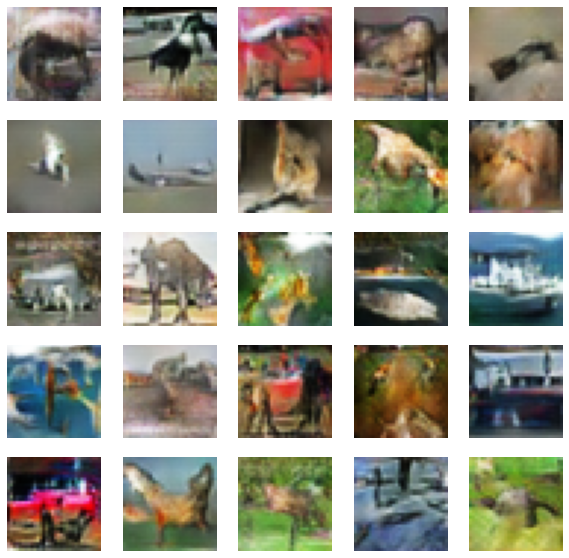

In [6]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
  fig = pyplot.figure(figsize=(10,10))
  for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(examples[i, :, :])
  pyplot.show()

# load model
#model = load_model('generator_model_2.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = g_model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 5)